In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chisquare
from scipy.stats import ttest_ind
import geopandas
from IPython.display import display

print(sns.color_palette("rocket").as_hex())



['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f']


In [2]:
old_college_df = pd.read_excel(io='data/original_data/Universities.xlsx',sheet_name="usnews3.data.9 .SS (v5.0)", index_col=0)

print(len(old_college_df))

old_college_df = old_college_df.dropna().count()
print(old_college_df)

1302
State                       471
Public (1)/ Private (2)     471
# appli. rec'd              471
# appl. accepted            471
# new stud. enrolled        471
% new stud. from top 10%    471
% new stud. from top 25%    471
# FT undergrad              471
# PT undergrad              471
in-state tuition            471
out-of-state tuition        471
room                        471
board                       471
add. fees                   471
estim. book costs           471
estim. personal $           471
% fac. w/PHD                471
stud./fac. ratio            471
Graduation rate             471
dtype: int64


In [3]:
college_df = pd.read_excel(io='data/geocode_college_with_address.xlsx', index_col=0)

college_df.dtypes






State                           object
Public/Private                   int64
Applicantions Received         float64
Applications Accepted          float64
New Students Enrolled          float64
% New Students from Top 10%    float64
% New Students from Top 25%    float64
# FT undergrad                 float64
# PT undergrad                 float64
in-state tuition               float64
out-of-state tuition           float64
room                           float64
board                          float64
add. fees                      float64
estim. book costs              float64
Estimated Personal Cost        float64
Faculty with PHD               float64
Student to Faculty Ratio       float64
Graduation rate                float64
Latitude                       float64
Longitude                      float64
County                          object
Address1                        object
Address2                        object
Zip Code                        object
Region                   

In [4]:
def IQR_outlier_report(column_list):
    
    '''
    This function takes list and returns a report
    of the number of outliers in the column based on the IQR method.
    '''
    q1 = column_list.quantile(.25)
    q3 = column_list.quantile(.75)
    # print(column)
    # print(f'Q1: {q1}')
    # print(f'Q3: {q3}')
    q2 = column_list.quantile(.5)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound, q1, q3, q2

In [5]:
print(type(college_df))
lower_bound, upper_bound, q1, q3, q2 = IQR_outlier_report(college_df['Student to Faculty Ratio'])
print(lower_bound, q2)

college_df['Student to Faculty Ratio']=college_df['Student to Faculty Ratio'].replace(college_df['Student to Faculty Ratio']> lower_bound)




<class 'pandas.core.frame.DataFrame'>
3.0999999999999996 14.3


Bin Edges: [  480.   1743.5  3007.   4270.5  5534.   6797.5  8061.   9324.5 10588.
 11851.5 13115.  14378.5 15642.  16905.5 18169.  19432.5 20696.  21959.5
 23223.  24486.5 25750. ]
Bin Sizes: [1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5
 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5]


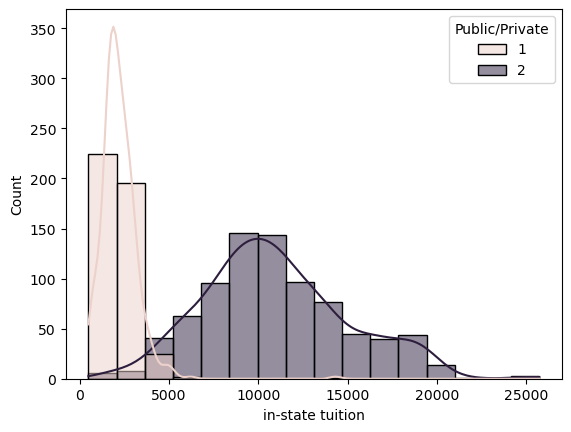

In [6]:
clean_intution_df = college_df.dropna(subset=['in-state tuition'])
sns.histplot(x='in-state tuition',data=clean_intution_df,bins="auto", kde=True, hue="Public/Private")

counts, bin_edges = np.histogram(clean_intution_df['in-state tuition'], bins=20)
bin_sizes = np.diff(bin_edges)

print("Bin Edges:", bin_edges)
print("Bin Sizes:", bin_sizes)


State                            0
Public/Private                   0
Applicantions Received          10
Applications Accepted           11
New Students Enrolled            5
% New Students from Top 10%    235
% New Students from Top 25%    202
# FT undergrad                   3
# PT undergrad                  32
in-state tuition                30
out-of-state tuition            20
room                           321
board                          498
add. fees                      274
estim. book costs               48
Estimated Personal Cost        181
Faculty with PHD                32
Student to Faculty Ratio         2
Graduation rate                 98
Latitude                         5
Longitude                        5
County                          44
Address1                         5
Address2                         5
Zip Code                       386
Region                           9
dtype: int64


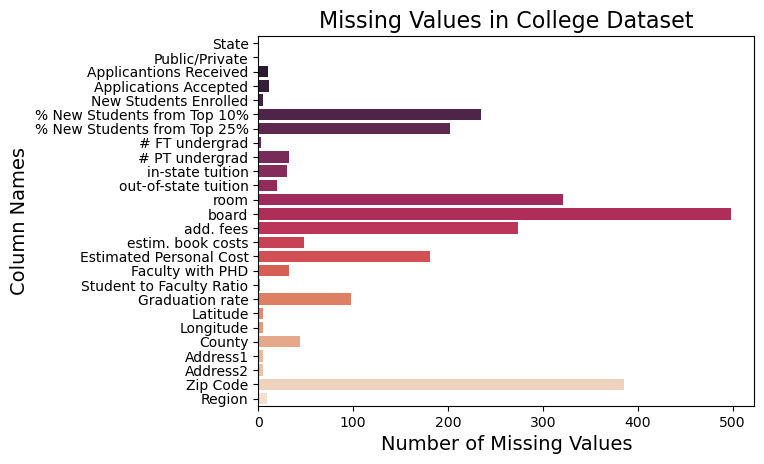

In [7]:
newcollege=college_df.isna().sum()
print(newcollege)

ax=sns.barplot( y=newcollege.index, x=newcollege.values, label="Total", palette="rocket", orient='h')
plt.title('Missing Values in College Dataset', fontsize=16)
plt.xlabel('Number of Missing Values', fontsize=14)
plt.ylabel('Column Names', fontsize=14)
plt.savefig('images/missing_values_college.png', bbox_inches='tight')
plt.show()

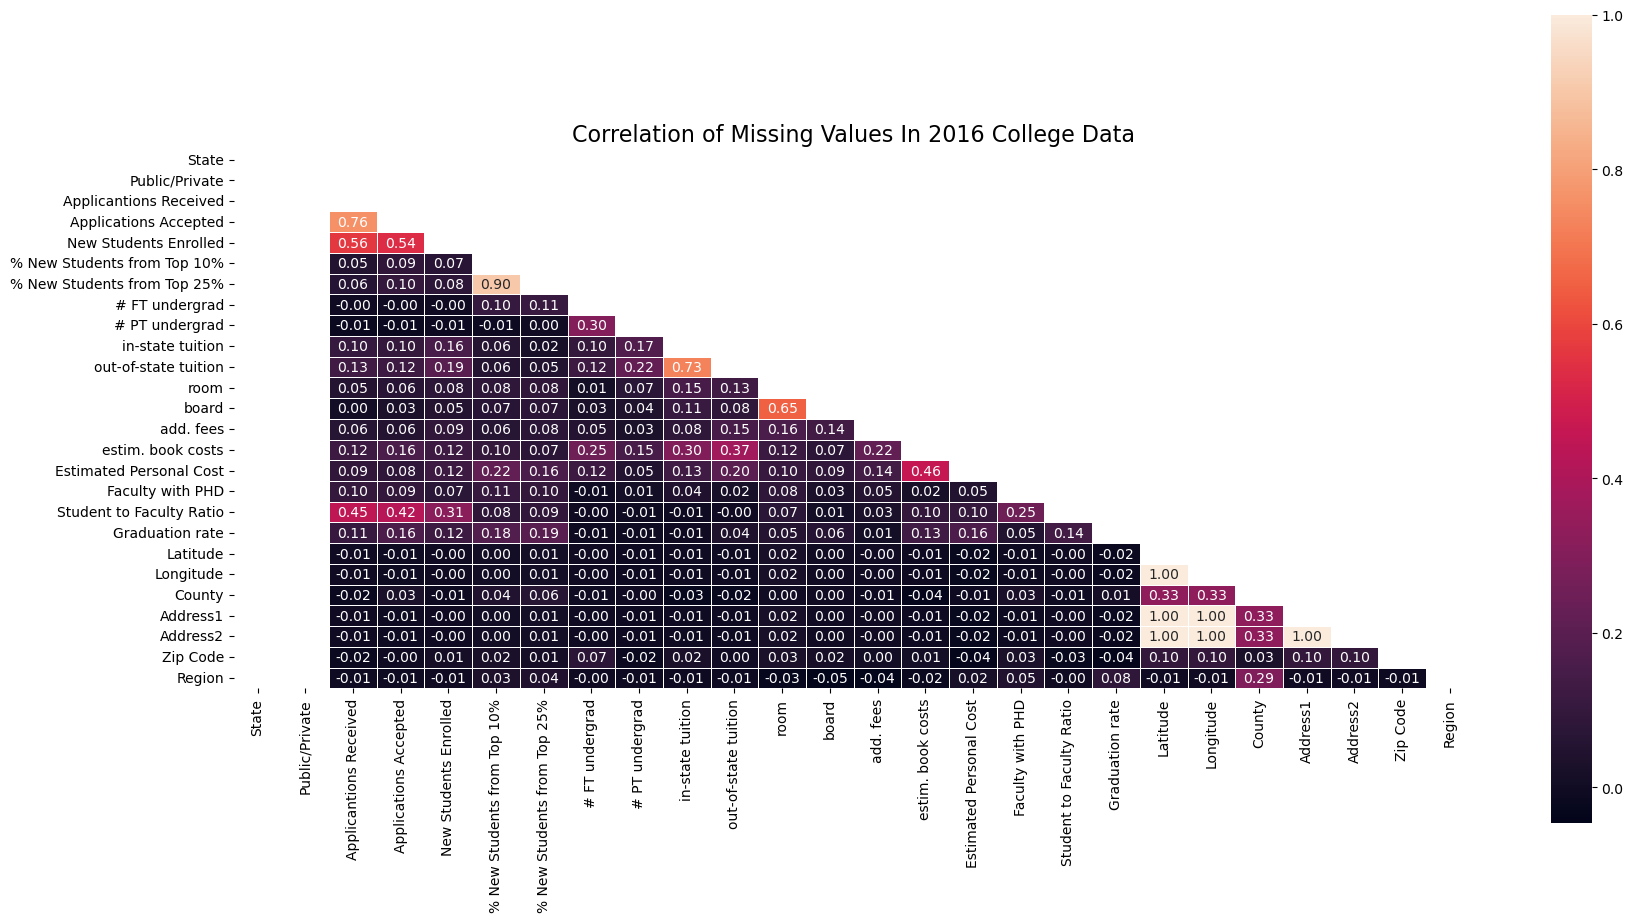

State                          325
Public/Private                 325
Applicantions Received         325
Applications Accepted          325
New Students Enrolled          325
% New Students from Top 10%    325
% New Students from Top 25%    325
# FT undergrad                 325
# PT undergrad                 325
in-state tuition               325
out-of-state tuition           325
room                           325
board                          325
add. fees                      325
estim. book costs              325
Estimated Personal Cost        325
Faculty with PHD               325
Student to Faculty Ratio       325
Graduation rate                325
Latitude                       325
Longitude                      325
County                         325
Address1                       325
Address2                       325
Zip Code                       325
Region                         325
dtype: int64
1302


In [8]:
missing_data = college_df.isna()
missing_data
plt.figure(figsize=(20, 7))

mask = np.triu(np.ones_like(missing_data.corr()))
sns.heatmap(missing_data.corr(), cmap="rocket", annot=True, linewidths=0.5, mask=mask,annot_kws={'size': 10}, cbar_kws={"shrink": 1.5}, fmt=".2f")
plt.title('Correlation of Missing Values In 2016 College Data', fontsize=16)
plt.savefig('images/missing_values_correlation_college.png', bbox_inches='tight')
plt.show()

dropna_df = college_df.dropna().count()

print(dropna_df)
print(len(college_df))


In [9]:
## Coerrelation

/var/folders/tq/t8mtqv314lg2510yzpslscmw0000gn/T/ipykernel_40439/1015165064.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(college_df.corr()))
/var/folders/tq/t8mtqv314lg2510yzpslscmw0000gn/T/ipykernel_40439/1015165064.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataplot = sns.heatmap(college_df.corr(), cmap="rocket", annot=True, linewidths=0.5, mask=mask, annot_kws={'size': 10}, cbar_kws={"shrink": 1.5}, fmt='.2f')


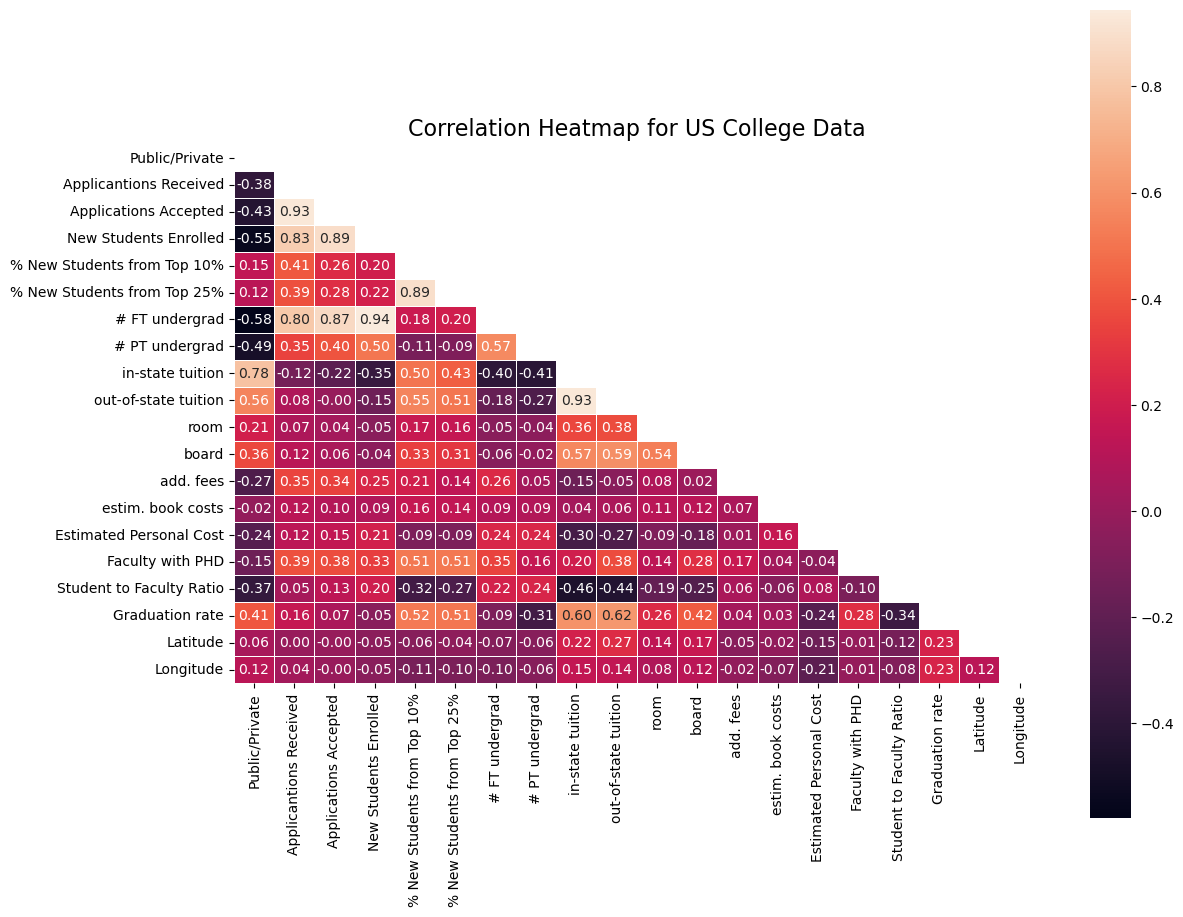

<Figure size 2000x1500 with 0 Axes>

In [10]:
mask = np.triu(np.ones_like(college_df.corr()))
plt.figure(figsize=(13, 7))

dataplot = sns.heatmap(college_df.corr(), cmap="rocket", annot=True, linewidths=0.5, mask=mask, annot_kws={'size': 10}, cbar_kws={"shrink": 1.5}, fmt='.2f')
plt.title('Correlation Heatmap for US College Data', fontsize=16)
plt.figure(figsize=(20,15))
plt.savefig('images/correlation_heatmap_college.png', bbox_inches='tight')
plt.show()



### Outliers

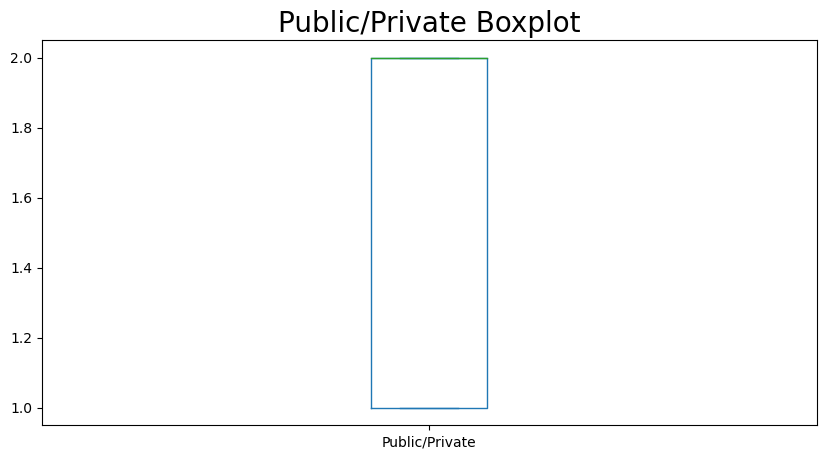

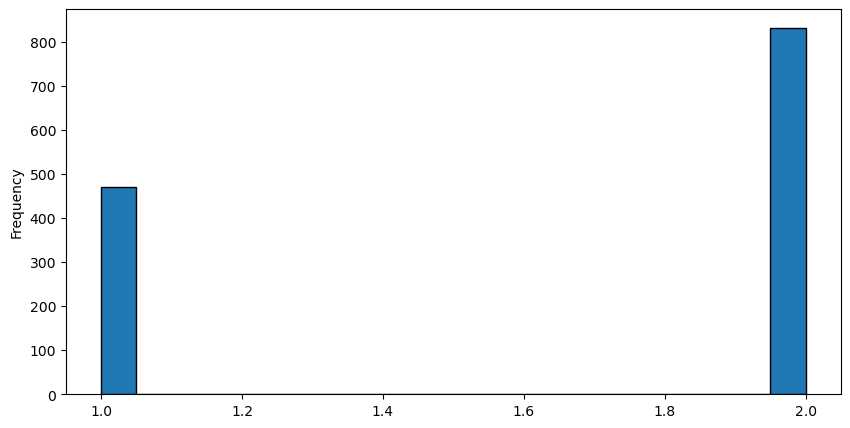

Public/Private outliers: 0
Outlier Upper bound: 3.5
Outlier Lower bound: -0.5
Q1: 1.0
Q2: 2.0
Q3: 2.0
Mean: 1.6390168970814132
Standard Deviation: 0.4804701944013999
Variance: 0.230851607708119
Min: 1, Max: 2
Skewness: -0.5795604840971722
Kurtosis: -1.6666721820329844


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,


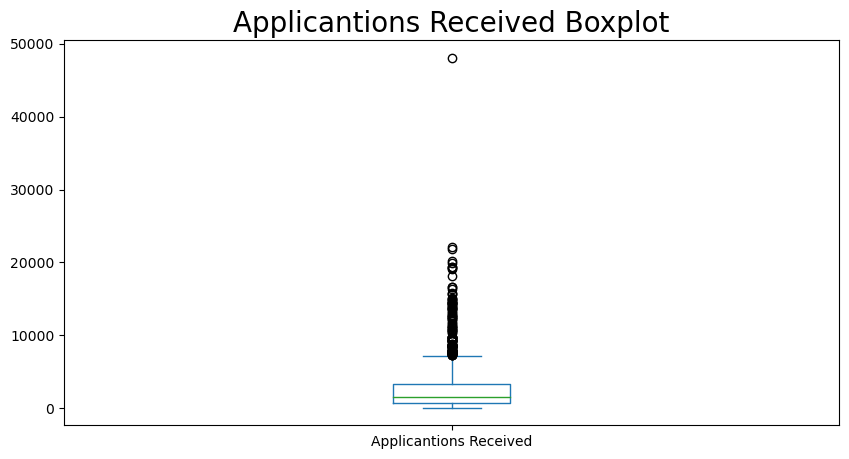

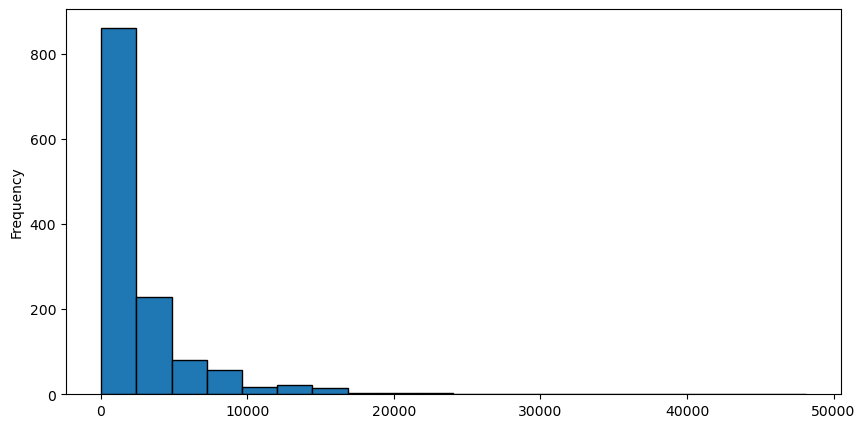

Applicantions Received outliers: 121
Outlier Upper bound: 7242.0
Outlier Lower bound: -3232.0
Q1: 695.75
Q2: 1470.0
Q3: 3314.25
Mean: 2752.0975232198143
Standard Deviation: 3541.9747123142993
Variance: 12545584.862673964
Min: 35.0, Max: 48094.0
Skewness: 3.660670627676559
Kurtosis: 25.783788263550182


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Auburn University-Main Campus,AL,1,7548.0,6791.0,3070.0,25.0,57.0,16262.0,1716.0,2100.0,...,85.0,16.7,69.0,32.591988,-85.495949,Lee County,Auburn University,"Auburn, AL 36849, United States of America",36849,South
University of Alabama at Tuscaloosa,AL,1,7593.0,5972.0,2682.0,NaN,57.0,13780.0,1599.0,2172.0,...,80.0,17.3,50.0,33.212887,-87.539239,Tuscaloosa County,University of Alabama,"Tuscaloosa, AL 35402, United States of America",35402,South
Arizona State University Main campus,AZ,1,12809.0,10308.0,3761.0,24.0,49.0,22593.0,7585.0,1828.0,...,88.0,18.9,48.0,33.421317,-111.933159,Maricopa County,Arizona State University,"1151 South Forest Avenue, Tempe, AZ 85281, Uni...",85281,West
University of Arizona,AZ,1,14079.0,12238.0,4529.0,29.0,57.0,21664.0,4894.0,1828.0,...,91.0,19.6,49.0,32.235640,-110.951744,Pima County,University of Arizona,"North 2nd Avenue, Tucson, AZ 85721, United Sta...",85721,West
California State Univ. at Long Beach,CA,1,10278.0,7746.0,2576.0,NaN,NaN,NaN,NaN,1053.0,...,80.0,20.3,48.0,33.783431,-118.115522,Los Angeles County,"California State University, Long Beach","Long Beach, CA, United States of America",NaN,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
University of Virginia,VA,1,15849.0,5384.0,2678.0,74.0,95.0,11278.0,114.0,3724.0,...,90.0,9.5,95.0,38.041058,-78.505500,NaN,University of Virginia,"Morton Drive, Charlottesville, VA 22901, Unite...",22901,South
University of Vermont,VT,1,7663.0,6008.0,1735.0,18.0,51.0,7353.0,1674.0,6210.0,...,87.0,9.9,79.0,44.478240,-73.199959,Chittenden County,University of Vermont green,"Burlington, VT, United States of America",NaN,North
University of Washington,WA,1,12749.0,7025.0,3343.0,40.0,81.0,20356.0,4582.0,2907.0,...,96.0,9.0,65.0,47.654347,-122.308061,King County,University of Washington,"Burke-Gilman Trail, Seattle, WA 98105, United ...",98105,West


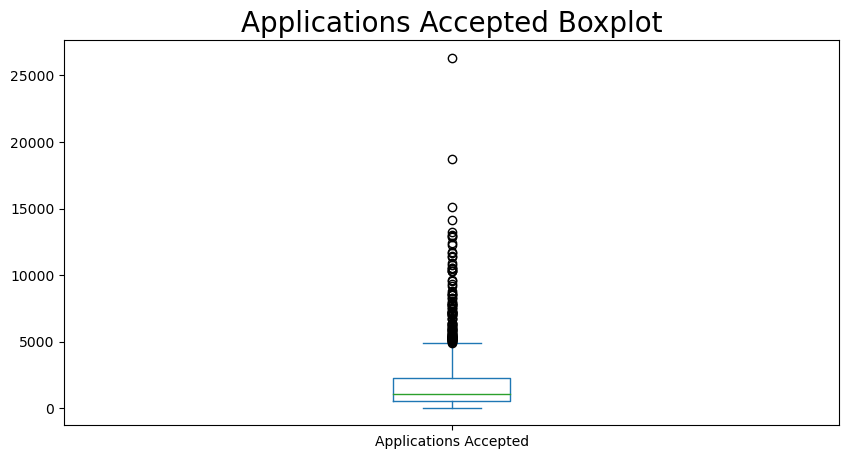

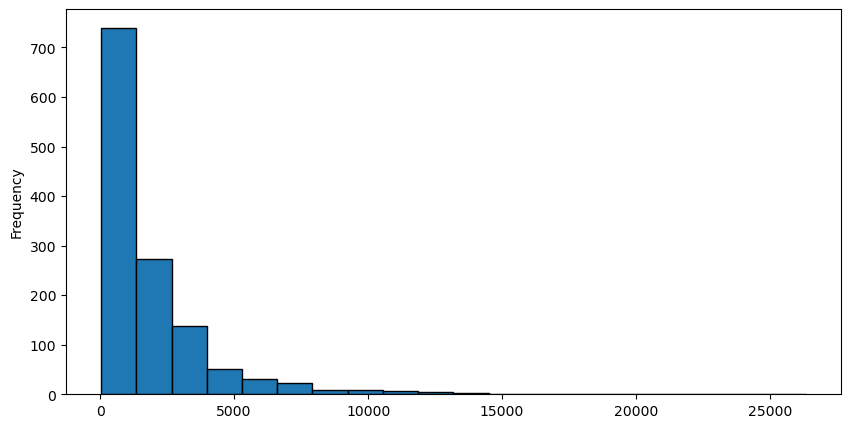

Applications Accepted outliers: 105
Outlier Upper bound: 4925.75
Outlier Lower bound: -2068.25
Q1: 554.5
Q2: 1095.0
Q3: 2303.0
Mean: 1870.6831913245546
Standard Deviation: 2250.866400187368
Variance: 5066399.551492441
Min: 35.0, Max: 26330.0
Skewness: 3.397188335142148
Kurtosis: 18.87699922158456


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Auburn University-Main Campus,AL,1,7548.0,6791.0,3070.0,25.0,57.0,16262.0,1716.0,2100.0,...,85.0,16.7,69.0,32.591988,-85.495949,Lee County,Auburn University,"Auburn, AL 36849, United States of America",36849,South
University of Alabama at Tuscaloosa,AL,1,7593.0,5972.0,2682.0,NaN,57.0,13780.0,1599.0,2172.0,...,80.0,17.3,50.0,33.212887,-87.539239,Tuscaloosa County,University of Alabama,"Tuscaloosa, AL 35402, United States of America",35402,South
Arizona State University Main campus,AZ,1,12809.0,10308.0,3761.0,24.0,49.0,22593.0,7585.0,1828.0,...,88.0,18.9,48.0,33.421317,-111.933159,Maricopa County,Arizona State University,"1151 South Forest Avenue, Tempe, AZ 85281, Uni...",85281,West
Northern Arizona University,AZ,1,5891.0,4931.0,1973.0,23.0,48.0,11249.0,2682.0,1828.0,...,78.0,21.7,41.0,35.183443,-111.655000,Coconino County,Northern Arizona University,"East Benton Avenue, Flagstaff, AZ 86011, Unite...",86011,West
University of Arizona,AZ,1,14079.0,12238.0,4529.0,29.0,57.0,21664.0,4894.0,1828.0,...,91.0,19.6,49.0,32.235640,-110.951744,Pima County,University of Arizona,"North 2nd Avenue, Tucson, AZ 85721, United Sta...",85721,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
University of Vermont,VT,1,7663.0,6008.0,1735.0,18.0,51.0,7353.0,1674.0,6210.0,...,87.0,9.9,79.0,44.478240,-73.199959,Chittenden County,University of Vermont green,"Burlington, VT, United States of America",NaN,North
University of Washington,WA,1,12749.0,7025.0,3343.0,40.0,81.0,20356.0,4582.0,2907.0,...,96.0,9.0,65.0,47.654347,-122.308061,King County,University of Washington,"Burke-Gilman Trail, Seattle, WA 98105, United ...",98105,West
Washington State University,WA,1,6540.0,5839.0,2440.0,31.0,70.0,14445.0,1344.0,2907.0,...,84.0,16.9,56.0,46.733772,-117.149761,Whitman County,Washington State University,"Northeast Fairway Lane, Pullman, WA 99164, Uni...",99164,West


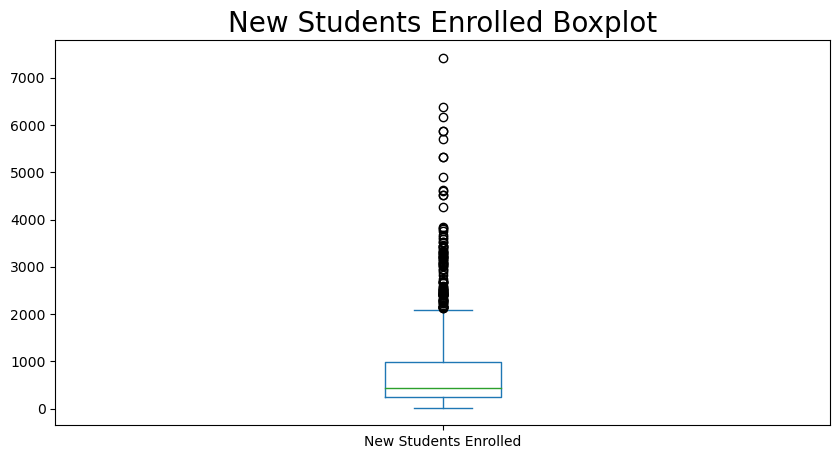

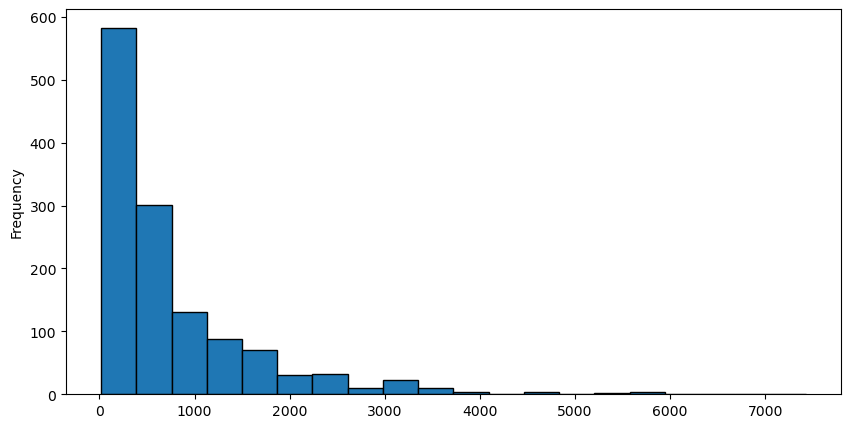

New Students Enrolled outliers: 103
Outlier Upper bound: 2106.0
Outlier Lower bound: -886.0
Q1: 236.0
Q2: 447.0
Q3: 984.0
Mean: 778.8804934464148
Standard Deviation: 884.5782738626799
Variance: 782478.7225898782
Min: 18.0, Max: 7425.0
Skewness: 2.6682974683980207
Kurtosis: 9.77303246041753


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Auburn University-Main Campus,AL,1,7548.0,6791.0,3070.0,25.0,57.0,16262.0,1716.0,2100.0,...,85.0,16.7,69.0,32.591988,-85.495949,Lee County,Auburn University,"Auburn, AL 36849, United States of America",36849,South
University of Alabama at Tuscaloosa,AL,1,7593.0,5972.0,2682.0,NaN,57.0,13780.0,1599.0,2172.0,...,80.0,17.3,50.0,33.212887,-87.539239,Tuscaloosa County,University of Alabama,"Tuscaloosa, AL 35402, United States of America",35402,South
University of Arkansas at Fayetteville,AR,1,3235.0,3108.0,2133.0,25.0,65.0,9978.0,1530.0,1932.0,...,73.0,14.8,39.0,36.093524,-94.177090,Washington County,University of Arkansas,"West Stone Street, Fayetteville, AR 72701, Uni...",72701,South
Arizona State University Main campus,AZ,1,12809.0,10308.0,3761.0,24.0,49.0,22593.0,7585.0,1828.0,...,88.0,18.9,48.0,33.421317,-111.933159,Maricopa County,Arizona State University,"1151 South Forest Avenue, Tempe, AZ 85281, Uni...",85281,West
University of Arizona,AZ,1,14079.0,12238.0,4529.0,29.0,57.0,21664.0,4894.0,1828.0,...,91.0,19.6,49.0,32.235640,-110.951744,Pima County,University of Arizona,"North 2nd Avenue, Tucson, AZ 85721, United Sta...",85721,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
University of Virginia,VA,1,15849.0,5384.0,2678.0,74.0,95.0,11278.0,114.0,3724.0,...,90.0,9.5,95.0,38.041058,-78.505500,NaN,University of Virginia,"Morton Drive, Charlottesville, VA 22901, Unite...",22901,South
University of Washington,WA,1,12749.0,7025.0,3343.0,40.0,81.0,20356.0,4582.0,2907.0,...,96.0,9.0,65.0,47.654347,-122.308061,King County,University of Washington,"Burke-Gilman Trail, Seattle, WA 98105, United ...",98105,West
Washington State University,WA,1,6540.0,5839.0,2440.0,31.0,70.0,14445.0,1344.0,2907.0,...,84.0,16.9,56.0,46.733772,-117.149761,Whitman County,Washington State University,"Northeast Fairway Lane, Pullman, WA 99164, Uni...",99164,West


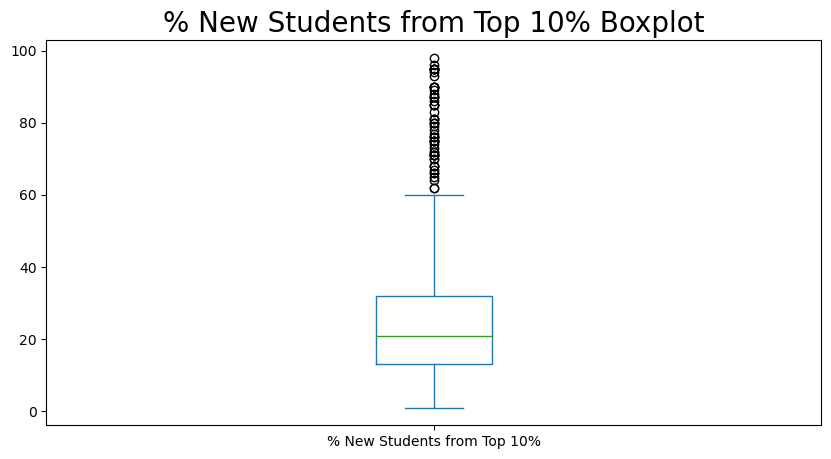

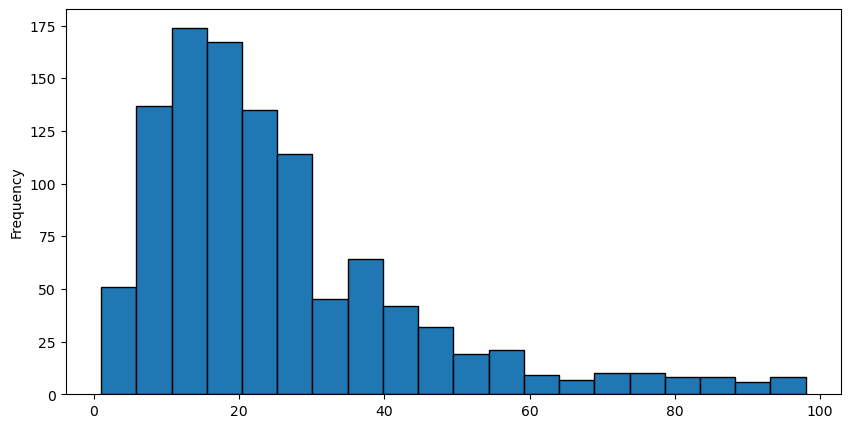

% New Students from Top 10% outliers: 60
Outlier Upper bound: 60.5
Outlier Lower bound: -15.5
Q1: 13.0
Q2: 21.0
Q3: 32.0
Mean: 25.67197750702905
Standard Deviation: 18.312617579038694
Variance: 335.35196259611695
Min: 1.0, Max: 98.0
Skewness: 1.5949103575923305
Kurtosis: 2.7157832654502783


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Birmingham-Southern College,AL,2,805.0,588.0,287.0,67.0,88.0,1376.0,207.0,11660.0,...,74.0,14.0,72.0,33.516185,-86.855847,Jefferson County,Birmingham Southern College,"Arkadelphia Road, Birmingham, AL 35204, United...",35204,South
California Institute of Technology,CA,2,1916.0,507.0,210.0,98.0,100.0,912.0,NaN,16695.0,...,100.0,6.5,83.0,34.137014,-118.125288,Los Angeles County,California Institute of Technology,"San Pasqual Street, Pasadena, CA 91125, United...",91125,West
Claremont McKenna College,CA,2,1860.0,767.0,227.0,71.0,93.0,887.0,1.0,17000.0,...,99.0,9.6,87.0,34.099958,-117.706179,Los Angeles County,Claremont McKenna College,"4th Street, Claremont, CA 91711, United States...",91711,West
Harvey Mudd College,CA,2,1377.0,572.0,178.0,95.0,100.0,654.0,5.0,17230.0,...,100.0,8.2,100.0,34.106140,-117.708728,Los Angeles County,Harvey Mudd College,"North Mills Avenue, Claremont, CA 91711, Unite...",91711,West
Pomona College,CA,2,3037.0,1130.0,390.0,80.0,98.0,1500.0,NaN,17720.0,...,94.0,8.9,91.0,34.061677,-117.738390,Los Angeles County,Pomona Junior College,"East Monterey Avenue, Pomona, CA 91767, United...",91767,West
Pepperdine University,CA,2,3821.0,2037.0,680.0,86.0,96.0,2488.0,625.0,18200.0,...,95.0,11.6,66.0,37.001023,-122.057770,Santa Cruz County,University Center,"College Nine Road, Santa Cruz, CA 95064, Unite...",95064,West
Stanford University,CA,2,13608.0,2926.0,1616.0,88.0,97.0,6573.0,NaN,18669.0,...,NaN,9.7,96.0,37.431314,-122.169365,Santa Clara County,Stanford University,"408 Panama Mall, Stanford, CA 94305, United St...",94305,West
University of California at Berkeley,CA,1,19873.0,8252.0,3215.0,95.0,100.0,19532.0,2061.0,3949.0,...,93.0,15.8,78.0,37.864020,-122.246121,Alameda County,"University of California, Berkeley - Clark Ker...","Berkeley, CA, United States of America",NaN,West
University of California at Davis,CA,1,16343.0,11399.0,3124.0,95.0,100.0,15429.0,1888.0,NaN,...,NaN,14.5,76.0,38.543590,-121.762470,Yolo County,University of California - Davis,"University of California Davis, CA, United Sta...",NaN,West


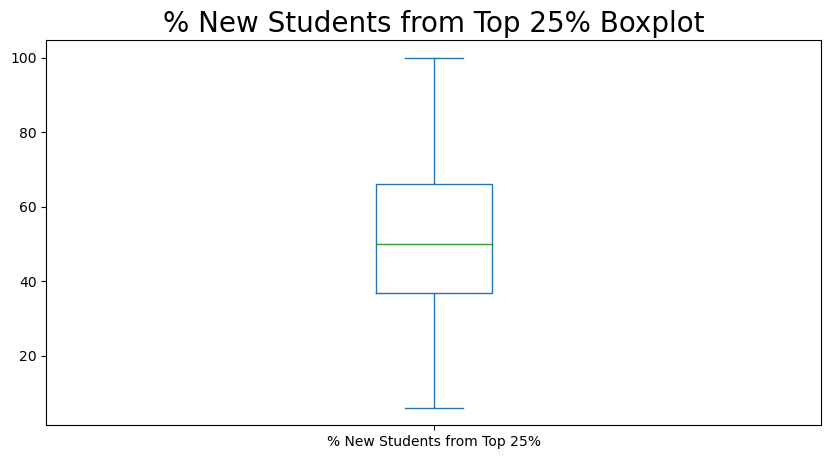

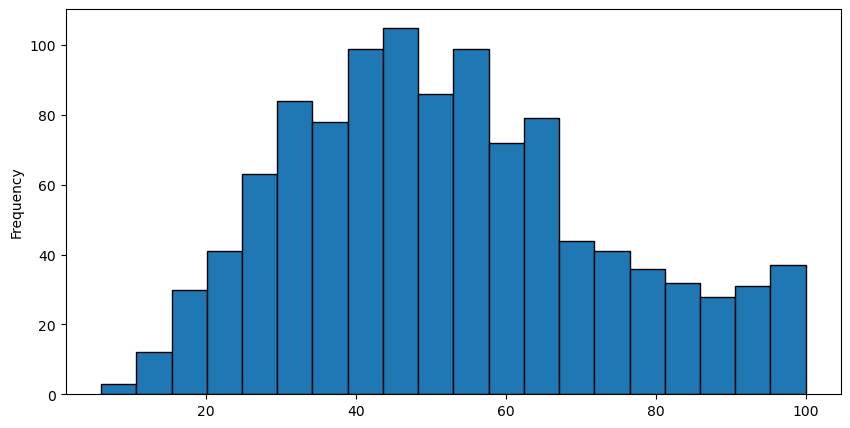

% New Students from Top 25% outliers: 0
Outlier Upper bound: 109.875
Outlier Lower bound: -7.125
Q1: 36.75
Q2: 50.0
Q3: 66.0
Mean: 52.35
Standard Deviation: 20.881315687929288
Variance: 436.02934485896185
Min: 6.0, Max: 100.0
Skewness: 0.40649473569649786
Kurtosis: -0.495701747082832


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,


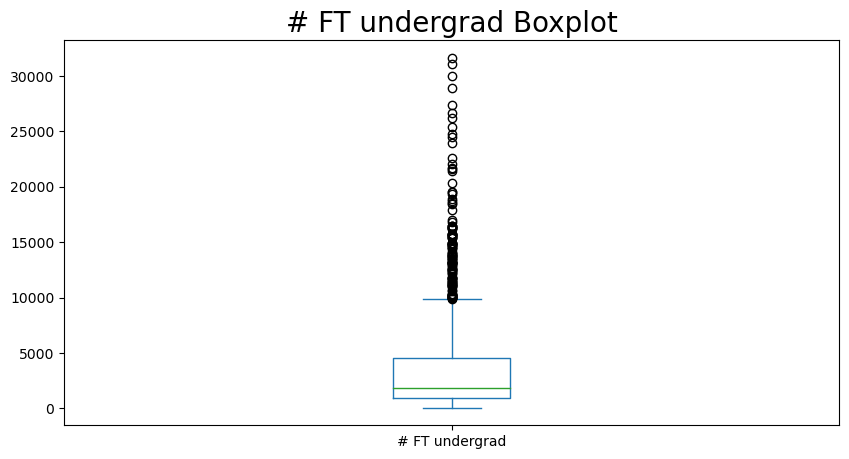

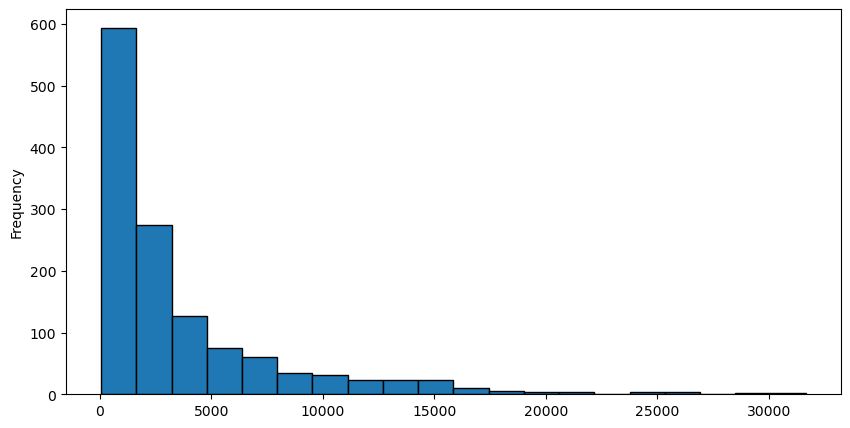

# FT undergrad outliers: 124
Outlier Upper bound: 9899.75
Outlier Lower bound: -4394.25
Q1: 966.0
Q2: 1812.0
Q3: 4539.5
Mean: 3692.6651270207853
Standard Deviation: 4544.847897272838
Variance: 20655642.409345336
Min: 59.0, Max: 31643.0
Skewness: 2.498443564005046
Kurtosis: 7.583331323934235


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Auburn University-Main Campus,AL,1,7548.0,6791.0,3070.0,25.0,57.0,16262.0,1716.0,2100.0,...,85.0,16.7,69.0,32.591988,-85.495949,Lee County,Auburn University,"Auburn, AL 36849, United States of America",36849,South
University of Alabama at Tuscaloosa,AL,1,7593.0,5972.0,2682.0,NaN,57.0,13780.0,1599.0,2172.0,...,80.0,17.3,50.0,33.212887,-87.539239,Tuscaloosa County,University of Alabama,"Tuscaloosa, AL 35402, United States of America",35402,South
University of Arkansas at Fayetteville,AR,1,3235.0,3108.0,2133.0,25.0,65.0,9978.0,1530.0,1932.0,...,73.0,14.8,39.0,36.093524,-94.177090,Washington County,University of Arkansas,"West Stone Street, Fayetteville, AR 72701, Uni...",72701,South
Arizona State University Main campus,AZ,1,12809.0,10308.0,3761.0,24.0,49.0,22593.0,7585.0,1828.0,...,88.0,18.9,48.0,33.421317,-111.933159,Maricopa County,Arizona State University,"1151 South Forest Avenue, Tempe, AZ 85281, Uni...",85281,West
Northern Arizona University,AZ,1,5891.0,4931.0,1973.0,23.0,48.0,11249.0,2682.0,1828.0,...,78.0,21.7,41.0,35.183443,-111.655000,Coconino County,Northern Arizona University,"East Benton Avenue, Flagstaff, AZ 86011, Unite...",86011,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
University of Washington,WA,1,12749.0,7025.0,3343.0,40.0,81.0,20356.0,4582.0,2907.0,...,96.0,9.0,65.0,47.654347,-122.308061,King County,University of Washington,"Burke-Gilman Trail, Seattle, WA 98105, United ...",98105,West
Washington State University,WA,1,6540.0,5839.0,2440.0,31.0,70.0,14445.0,1344.0,2907.0,...,84.0,16.9,56.0,46.733772,-117.149761,Whitman County,Washington State University,"Northeast Fairway Lane, Pullman, WA 99164, Uni...",99164,West
University of Wisconsin at Madison,WI,1,14901.0,10932.0,4631.0,36.0,80.0,23945.0,2200.0,2737.0,...,93.0,11.5,72.0,43.048631,-89.419739,Dane County,University of Wisconsin Arboretum,"Madison, WI, United States of America",NaN,Midwest


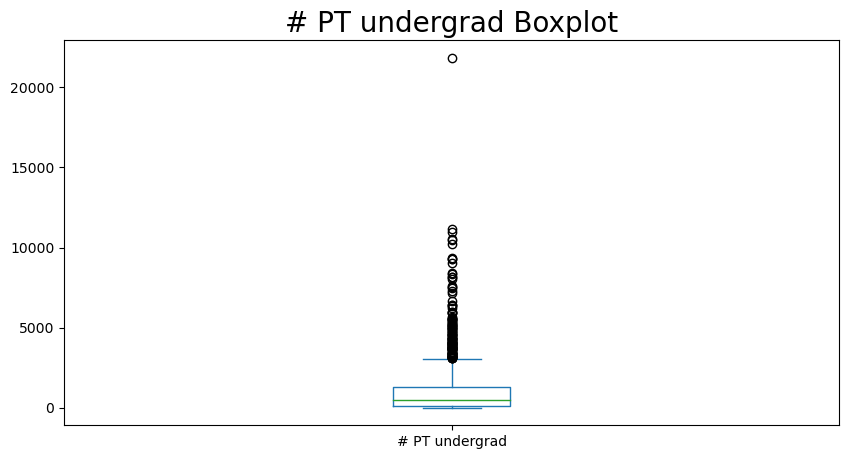

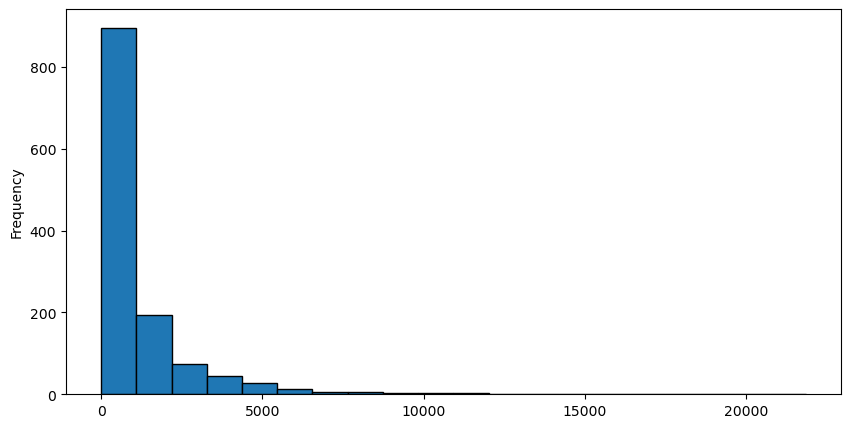

# PT undergrad outliers: 119
Outlier Upper bound: 3085.625
Outlier Lower bound: -1641.375
Q1: 131.25
Q2: 472.0
Q3: 1313.0
Mean: 1081.5267716535434
Standard Deviation: 1672.2029119915278
Variance: 2796262.578872945
Min: 1.0, Max: 21836.0
Skewness: 3.839905592711479
Kurtosis: 25.920814991815906


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
University of Alaska at Fairbanks,AK,1,1852.0,1427.0,928.0,NaN,NaN,3885.0,4519.0,1742.0,...,67.0,10.0,NaN,61.563915,-149.229834,Matanuska-Susitna,University of Alaska Fairbanks Experimental Fa...,"Monitor Well Jeep Road, Matanuska-Susitna, AK,...",NaN,West
University of Alaska at Anchorage,AK,1,2065.0,1598.0,1162.0,NaN,NaN,6209.0,10537.0,1742.0,...,48.0,13.7,NaN,42.380002,-88.175800,Lake County,Anchorage,"Grant, IL, United States of America",NaN,West
University of Alabama at Birmingham,AL,1,1797.0,1260.0,938.0,24.0,35.0,6960.0,4698.0,2220.0,...,96.0,6.7,33.0,33.506734,-86.803268,Jefferson County,University of Alabama Hospital Heliport,"5th Avenue South, Birmingham, AL 35212, United...",35212,South
University of Alabama at Huntsville,AL,1,1376.0,957.0,445.0,NaN,57.0,2727.0,3394.0,2480.0,...,83.0,12.7,38.0,34.723726,-86.596338,Madison County,Food Bank of North Alabama,"Huntsville, AL 35804, United States of America",35804,South
University of Arkansas at Little Rock,AR,1,1766.0,1322.0,1194.0,NaN,NaN,5753.0,4058.0,2136.0,...,61.0,14.7,19.0,34.748235,-92.325740,Pulaski County,University of Arkansas for Medical Sciences,"Little Rock, AR, United States of America",NaN,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Weber State University,UT,1,2632.0,2509.0,1750.0,NaN,46.0,8609.0,5680.0,1377.0,...,66.0,23.9,38.0,40.776890,-111.915493,Salt Lake County,University,"Salt Lake City, UT, United States of America",84180,West
Virginia Commonwealth University,VA,1,4963.0,3497.0,1567.0,18.0,45.0,10262.0,5065.0,3034.0,...,81.0,8.7,45.0,37.546125,-77.454061,NaN,Virginia Commonwealth University,"907 Floyd Avenue, Richmond, VA 23284, United S...",23284,South
George Mason University,VA,1,5653.0,4326.0,1727.0,17.0,29.0,9528.0,3822.0,4044.0,...,93.0,19.3,46.0,38.831333,-77.307988,Fairfax County,George Mason University,"4400 University Drive, Fairfax County, VA 2203...",22030,South


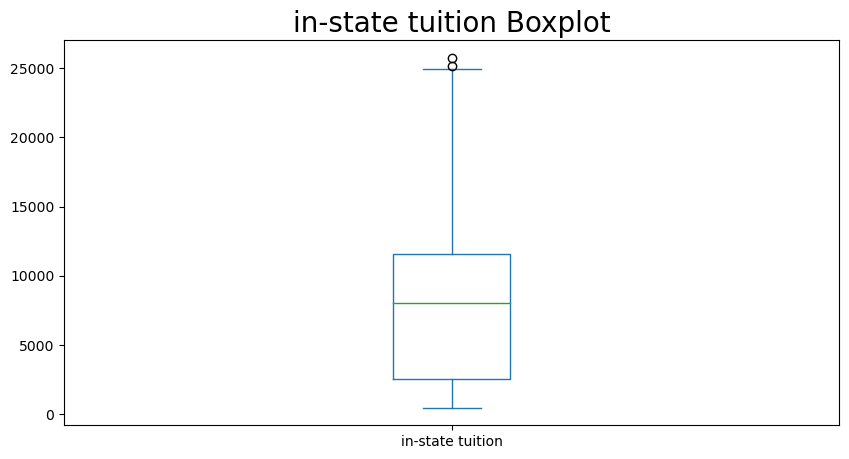

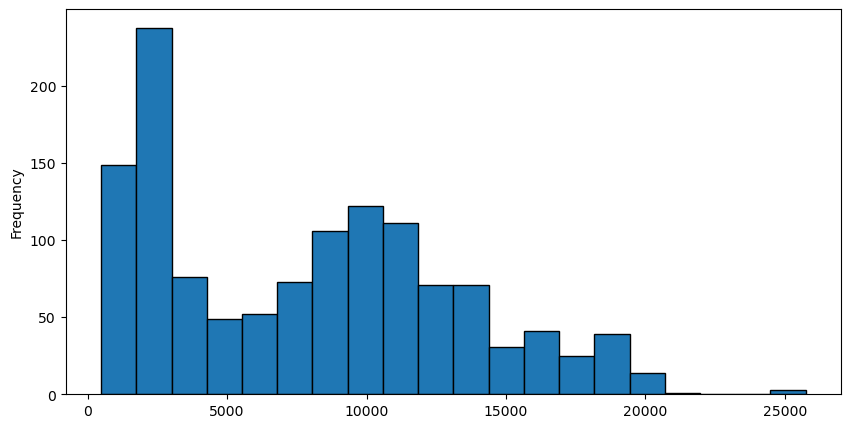

in-state tuition outliers: 2
Outlier Upper bound: 25130.0
Outlier Lower bound: -10950.0
Q1: 2580.0
Q2: 8050.0
Q3: 11600.0
Mean: 7897.274371069182
Standard Deviation: 5348.162626265424
Variance: 28602843.476982273
Min: 480.0, Max: 25750.0
Skewness: 0.43192828821128354
Kurtosis: -0.7445288040272655


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Bates College,ME,2,3461.0,1541.0,577.0,53.0,90.0,1599.0,NaN,25180.0,...,79.0,9.8,93.0,44.106083,-70.202322,Androscoggin County,Bates College,"Russell Street, Lewiston, ME 04240, United Sta...",04240,North
Middlebury College,VT,2,3456.0,1171.0,451.0,64.0,89.0,2016.0,39.0,25750.0,...,87.0,10.5,97.0,44.003670,-73.172953,Addison County,Middlebury College,"14 Old Chapel Road, Middlebury, VT 05753, Unit...",05753,North


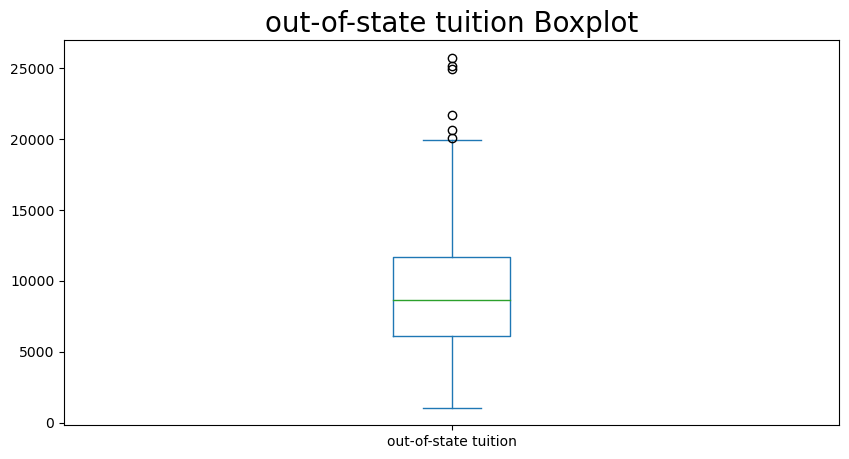

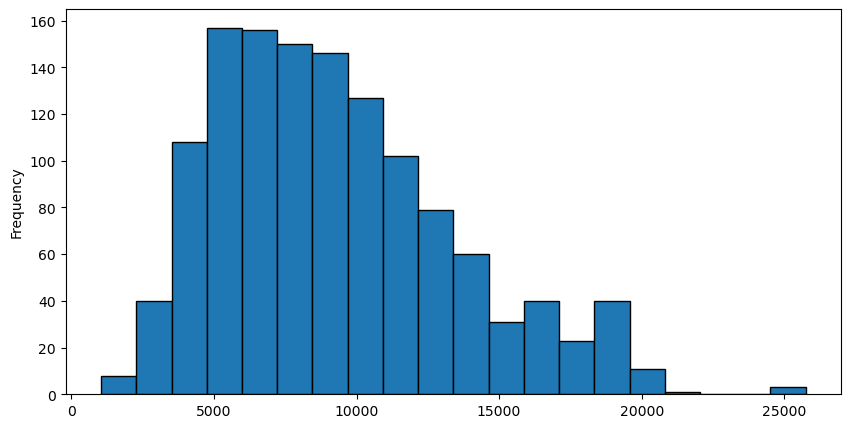

out-of-state tuition outliers: 6
Outlier Upper bound: 19981.0
Outlier Lower bound: -2211.0
Q1: 6111.0
Q2: 8670.0
Q3: 11659.0
Mean: 9276.905616224649
Standard Deviation: 4170.770850710118
Variance: 17395329.489133198
Min: 1044.0, Max: 25750.0
Skewness: 0.7335858390736513
Kurtosis: 0.1590734519832946


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Massachusetts Institute of Technology,MA,2,6411.0,2140.0,1078.0,96.0,99.0,4481.0,28.0,20100.0,...,99.0,10.1,94.0,42.358253,-71.096627,Middlesex County,Massachusetts Institute of Technology,"Vassar Street, Cambridge, MA 02215, United Sta...",02215,North
Hampshire College,MA,2,1342.0,998.0,309.0,26.0,56.0,1079.0,NaN,20655.0,...,79.0,11.4,62.0,42.325770,-72.532239,Hampshire County,Hampshire College,"Longsworth Road, Amherst, MA 01035, United Sta...",01035,North
Bates College,ME,2,3461.0,1541.0,577.0,53.0,90.0,1599.0,NaN,25180.0,...,79.0,9.8,93.0,44.106083,-70.202322,Androscoggin County,Bates College,"Russell Street, Lewiston, ME 04240, United Sta...",04240,North
Franklin and Marshall College,PA,2,3270.0,2120.0,508.0,46.0,80.0,1748.0,40.0,24940.0,...,93.0,10.9,86.0,40.048988,-76.320099,Lancaster County,Franklin & Marshall College,"Williamson Way, Lancaster, PA 17604, United St...",17604,North
Bennington College,VT,2,519.0,327.0,114.0,25.0,53.0,457.0,2.0,21700.0,...,35.0,10.1,55.0,42.920443,-73.238525,Bennington County,Bennington College Rd System,"Bennington, VT 05257, United States of America",05257,North
Middlebury College,VT,2,3456.0,1171.0,451.0,64.0,89.0,2016.0,39.0,25750.0,...,87.0,10.5,97.0,44.003670,-73.172953,Addison County,Middlebury College,"14 Old Chapel Road, Middlebury, VT 05753, Unit...",05753,North


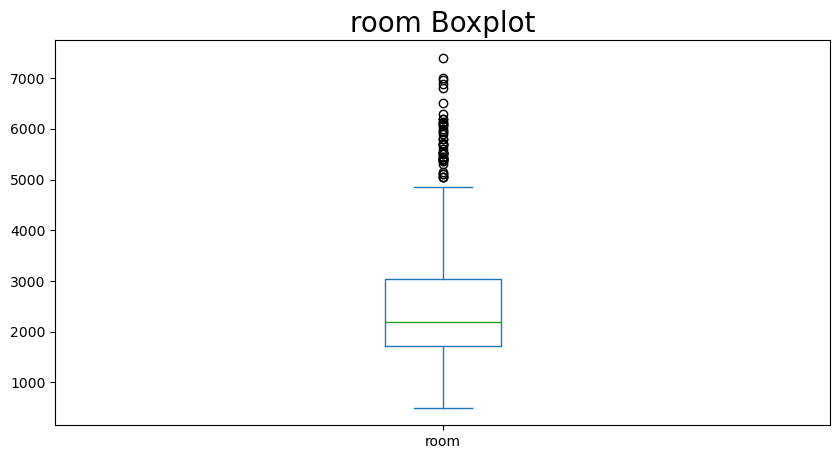

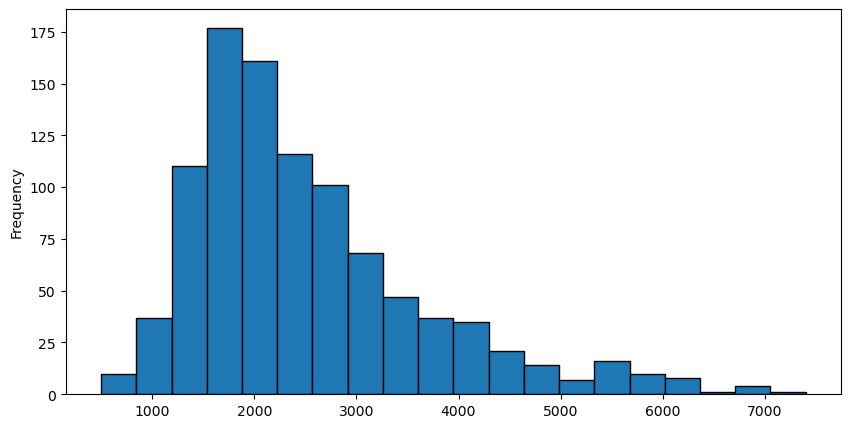

room outliers: 47
Outlier Upper bound: 5035.0
Outlier Lower bound: -285.0
Q1: 1710.0
Q2: 2200.0
Q3: 3040.0
Mean: 2514.6819571865444
Standard Deviation: 1150.8368484745242
Variance: 1324425.451806775
Min: 500.0, Max: 7400.0
Skewness: 1.2861783024319742
Kurtosis: 1.6936214926178375


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
California Lutheran University,CA,2,563.0,247.0,247.0,23.0,52.0,1427.0,432.0,12950.0,...,72.0,12.4,60.0,37.010527,-122.043932,Santa Cruz County,California Powder Works Bridge,"Keystone Way, Paradise Park, CA 95064, United ...",95064,West
Chapman University,CA,2,959.0,771.0,351.0,23.0,48.0,1662.0,209.0,16624.0,...,72.0,12.8,47.0,37.000881,-122.058056,Santa Cruz County,University Center,"Santa Cruz, CA 95064, United States of America",95064,West
College of Notre Dame,CA,2,344.0,264.0,97.0,11.0,42.0,500.0,331.0,12600.0,...,77.0,10.4,43.0,37.334476,-121.894648,Santa Clara County,College of Notre Dame,"Notre Dame Avenue, San Jose, CA 95110, United ...",95110,West
Dominican College of San Rafael,CA,2,213.0,173.0,75.0,NaN,NaN,648.0,150.0,12790.0,...,56.0,11.6,50.0,37.741890,-122.384584,San Francisco County,City College of San Francisco Evans,"San Francisco, CA 94188, United States of America",94188,West
University of La Verne,CA,2,1597.0,969.0,226.0,16.0,38.0,1431.0,1522.0,13540.0,...,66.0,14.1,47.0,34.099864,-117.772622,Los Angeles County,University of La Verne,"1st Street, La Verne, CA 91750, United States ...",91750,West
Menlo College,CA,2,315.0,275.0,115.0,NaN,NaN,553.0,9.0,13975.0,...,46.0,15.4,NaN,37.434832,-122.204583,San Mateo County,"West Menlo Park, CA",United States of America,NaN,West
Mount St. Mary's College,CA,2,657.0,537.0,113.0,37.0,90.0,1039.0,466.0,12474.0,...,53.0,11.9,72.0,37.841319,-122.109287,Contra Costa County,St. Mary's College of California,"Mission Rd, Moraga, CA 94575, United States of...",94575,West
University of California at Santa Cruz,CA,1,10758.0,8559.0,1717.0,94.0,100.0,8713.0,607.0,NaN,...,94.0,21.3,59.0,36.996236,-122.064432,Santa Cruz County,"University of California, Santa Cruz","Santa Cruz, CA, United States of America",NaN,West
Santa Clara University,CA,2,4019.0,2779.0,888.0,40.0,73.0,3891.0,128.0,13584.0,...,88.0,13.9,100.0,36.996236,-122.064432,Santa Cruz County,"University of California, Santa Cruz","Santa Cruz, CA, United States of America",NaN,West


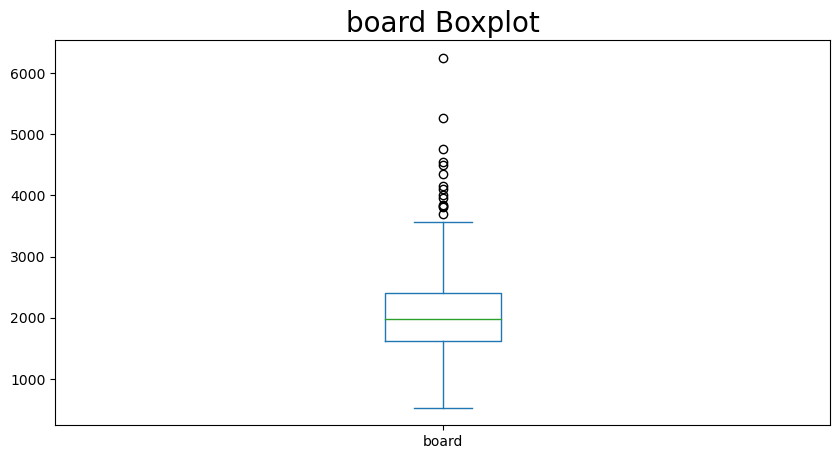

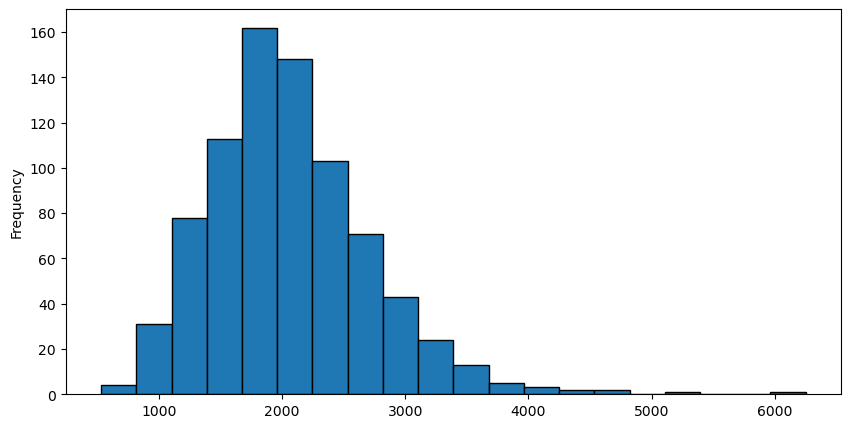

board outliers: 14
Outlier Upper bound: 3574.875
Outlier Lower bound: 445.875
Q1: 1619.25
Q2: 1980.0
Q3: 2401.5
Mean: 2060.983830845771
Standard Deviation: 661.7420994722554
Variance: 437902.6062139484
Min: 531.0, Max: 6250.0
Skewness: 1.0297016739965241
Kurtosis: 2.966950214036663


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Scripps College,CA,2,855.0,632.0,139.0,60.0,83.0,569.0,7.0,17238.0,...,95.0,8.2,73.0,34.103918,-117.709344,Los Angeles County,Scripps College,"10th Street, Claremont, CA 91711, United State...",91711,West
University of Hartford,CT,2,5081.0,4040.0,1194.0,11.0,26.0,3768.0,1415.0,14220.0,...,61.0,10.7,66.0,41.800265,-72.714121,Capitol Planning Region,University of Hartford,"200 Bloomfield Avenue, West Hartford, CT 06117...",06117,North
American University,DC,2,4613.0,3587.0,1048.0,35.0,77.0,4545.0,873.0,15934.0,...,NaN,13.6,69.0,38.938045,-77.089392,NaN,American University,"4400 Massachusetts Avenue Northwest, Washingto...",20016,NaN
Georgetown University,DC,2,11115.0,2881.0,1390.0,71.0,93.0,5881.0,406.0,18300.0,...,91.0,7.2,95.0,38.908939,-77.074580,NaN,Georgetown University,"3700 O Street Northwest, Washington, DC 20057,...",20057,NaN
Mount Vernon College,DC,2,149.0,70.0,61.0,15.0,35.0,203.0,138.0,13780.0,...,84.0,5.7,NaN,40.913831,-73.829466,Westchester County,"Mount Vernon, NY",United States of America,NaN,NaN
Columbia College,IL,2,2419.0,2160.0,1117.0,NaN,NaN,4852.0,1991.0,7310.0,...,18.0,13.4,41.0,41.875395,-87.626504,Cook County,Columbia College,"33 East Ida B. Wells Drive, Chicago, IL 60605,...",60605,Midwest
Babson College,MA,2,2007.0,1139.0,407.0,30.0,68.0,1680.0,NaN,16600.0,...,93.0,16.8,94.0,42.294996,-71.264917,Norfolk County,Babson College,"Great Plain Avenue, Wellesley, MA 02181, Unite...",02181,North
Boston College,MA,2,13112.0,6179.0,2154.0,66.0,94.0,8807.0,NaN,16640.0,...,95.0,16.6,90.0,42.335448,-71.168266,Middlesex County,Boston College,"140 Commonwealth Avenue, Newton, MA 02467, Uni...",02467,North
Cooper Union,NY,2,2339.0,307.0,197.0,NaN,100.0,959.0,26.0,NaN,...,67.0,8.1,95.0,43.623749,-73.543463,Warren County,Cooper Island,"Bolton, NY, United States of America",NaN,North


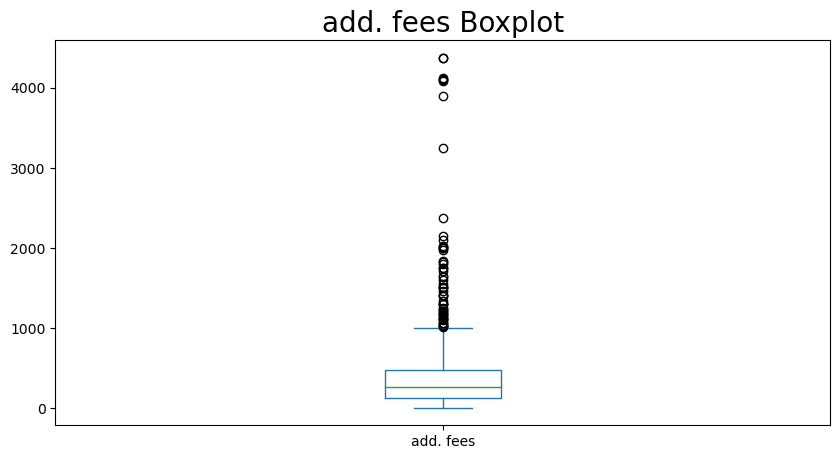

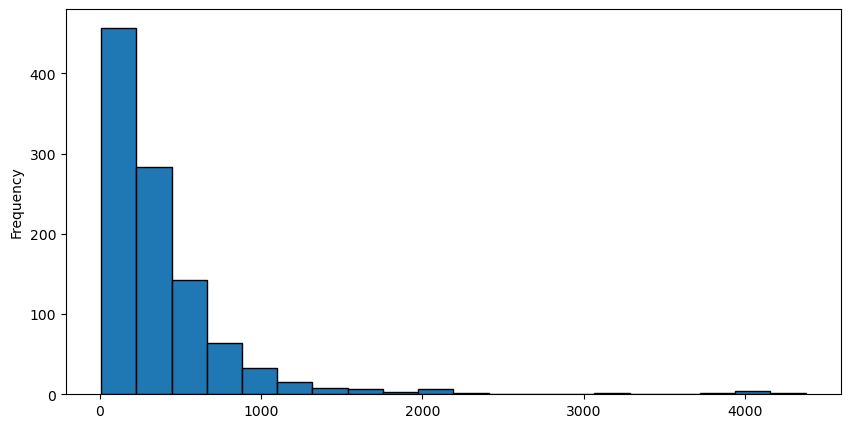

add. fees outliers: 55
Outlier Upper bound: 1005.0
Outlier Lower bound: -395.0
Q1: 130.0
Q2: 264.5
Q3: 480.0
Mean: 392.0126459143969
Standard Deviation: 469.3792341678182
Variance: 220316.8654679675
Min: 9.0, Max: 4374.0
Skewness: 4.5076575918479636
Kurtosis: 29.338147220975923


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Harding University,AR,2,1721.0,1068.0,806.0,35.0,75.0,3128.0,213.0,5504.0,...,71.0,17.7,73.0,36.323780,-94.185570,Benton County,Harding University,"I 49;US 62;US 71, Rogers, AR 72758, United Sta...",72758,South
California State Univ. at Fullerton,CA,1,6004.0,4480.0,1470.0,NaN,NaN,12147.0,6681.0,1606.0,...,88.0,19.9,56.0,33.873609,-117.903390,Orange County,United States Post Office: Fullerton California,"East Chapman Avenue, Fullerton, CA 92831, Unit...",92831,West
California Poly-Pomona,CA,1,5945.0,3887.0,1566.0,NaN,60.0,11177.0,4027.0,NaN,...,73.0,18.5,50.0,34.055948,-117.756785,Los Angeles County,"Pomona, CA",United States of America,NaN,West
California State University at Chico,CA,1,4816.0,3922.0,1278.0,NaN,75.0,11822.0,1343.0,NaN,...,NaN,18.9,63.0,33.530681,-117.035902,Riverside County,Calle Chico,"Riverside County, CA, United States of America",NaN,West
Humboldt State University,CA,1,3467.0,2190.0,565.0,NaN,NaN,5637.0,678.0,1599.0,...,80.0,16.4,65.0,36.992476,-122.058858,Santa Cruz County,University,"Santa Cruz, CA, United States of America",95064,West
California State University at Northridge,CA,1,7672.0,5331.0,2157.0,NaN,33.0,15567.0,7544.0,1440.0,...,NaN,20.3,43.0,34.244299,-118.530879,Los Angeles County,California State University Northridge Post Of...,"Los Angeles, CA 91325, United States of America",91325,West
Sonoma State University,CA,1,2726.0,982.0,557.0,47.0,84.0,4239.0,1259.0,NaN,...,79.0,16.1,40.0,38.290522,-122.459658,Sonoma County,"Sonoma, CA",United States of America,NaN,West
Pitzer College,CA,2,1133.0,630.0,220.0,37.0,73.0,750.0,30.0,17688.0,...,100.0,10.4,73.0,32.772488,-117.053002,San Diego County,College East,"San Diego, CA, United States of America",NaN,West
University of California at Davis,CA,1,16343.0,11399.0,3124.0,95.0,100.0,15429.0,1888.0,NaN,...,NaN,14.5,76.0,38.543590,-121.762470,Yolo County,University of California - Davis,"University of California Davis, CA, United Sta...",NaN,West


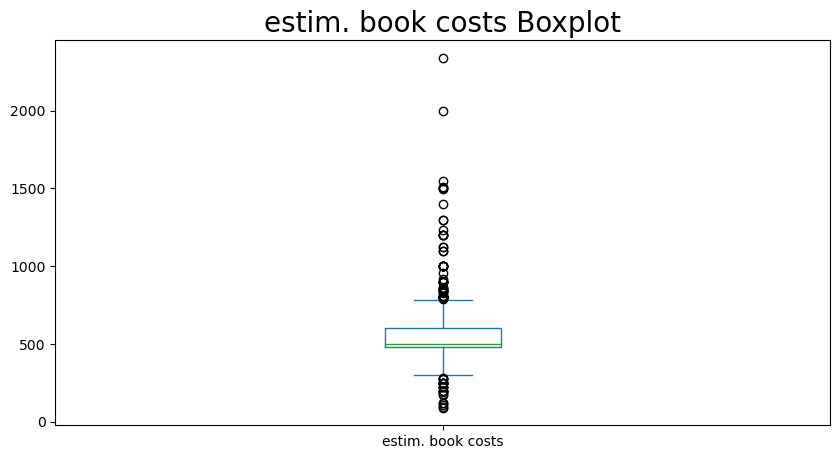

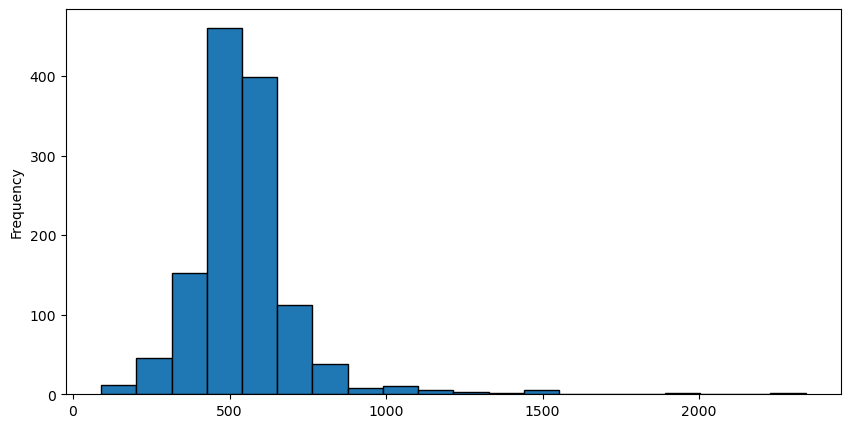

estim. book costs outliers: 95
Outlier Upper bound: 780.0
Outlier Lower bound: 300.0
Q1: 480.0
Q2: 502.0
Q3: 600.0
Mean: 549.9728867623604
Standard Deviation: 167.35538617517918
Variance: 28007.825281843354
Min: 90.0, Max: 2340.0
Skewness: 2.8580587414213525
Kurtosis: 20.34164582704872


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Alaska Pacific University,AK,2,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,...,76.0,11.9,15.0,57.440798,-152.354501,Kodiak Island Borough,Pacific Spaceport Complex Alaska,"Kodiak Island Borough, AK, United States of Am...",NaN,West
Talladega College,AL,2,4414.0,1500.0,335.0,30.0,60.0,908.0,119.0,5666.0,...,56.0,15.5,46.0,33.432513,-86.114888,Talladega County,Talladega College,"Cruikshank Street, Talladega, AL 35160, United...",35160,South
University of Arkansas at Little Rock,AR,1,1766.0,1322.0,1194.0,NaN,NaN,5753.0,4058.0,2136.0,...,61.0,14.7,19.0,34.748235,-92.325740,Pulaski County,University of Arkansas for Medical Sciences,"Little Rock, AR, United States of America",NaN,South
Azusa Pacific University,CA,2,1080.0,948.0,504.0,25.0,56.0,2032.0,122.0,15500.0,...,47.0,12.8,NaN,36.992476,-122.058858,Santa Cruz County,University,"Santa Cruz, CA, United States of America",95064,West
Biola University,CA,2,1118.0,896.0,459.0,NaN,NaN,2058.0,111.0,11388.0,...,67.0,16.6,36.0,37.000881,-122.058056,Santa Cruz County,University Center,"Santa Cruz, CA 95064, United States of America",95064,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
University of Utah,UT,1,5095.0,4491.0,2400.0,27.0,53.0,13894.0,8374.0,1954.0,...,89.0,12.8,37.0,40.762814,-111.836872,Salt Lake County,University of Utah,"201 Presidents Circle, Salt Lake City, UT 8411...",84112,West
Washington State University,WA,1,6540.0,5839.0,2440.0,31.0,70.0,14445.0,1344.0,2907.0,...,84.0,16.9,56.0,46.733772,-117.149761,Whitman County,Washington State University,"Northeast Fairway Lane, Pullman, WA 99164, Uni...",99164,West
Milwaukee School of Engineering,WI,2,1217.0,1088.0,496.0,36.0,69.0,1773.0,884.0,11505.0,...,35.0,16.7,67.0,43.045766,-87.907936,Milwaukee County,Milwaukee School of Engineering,"North Jefferson Street, Milwaukee, WI 53203, U...",53203,Midwest


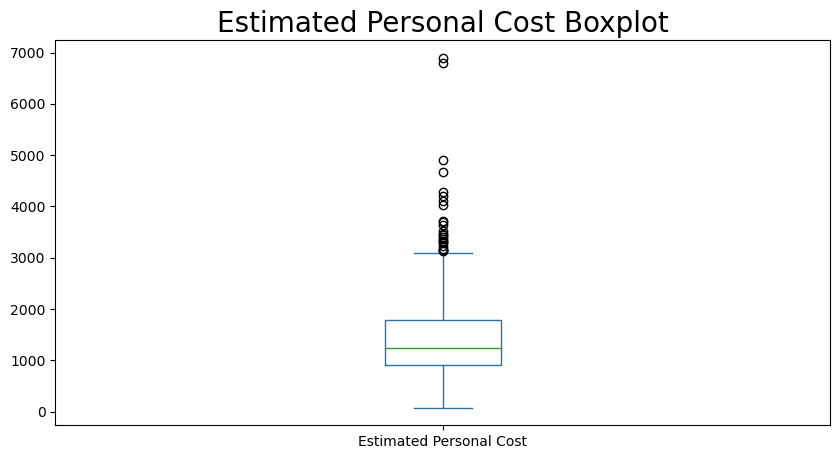

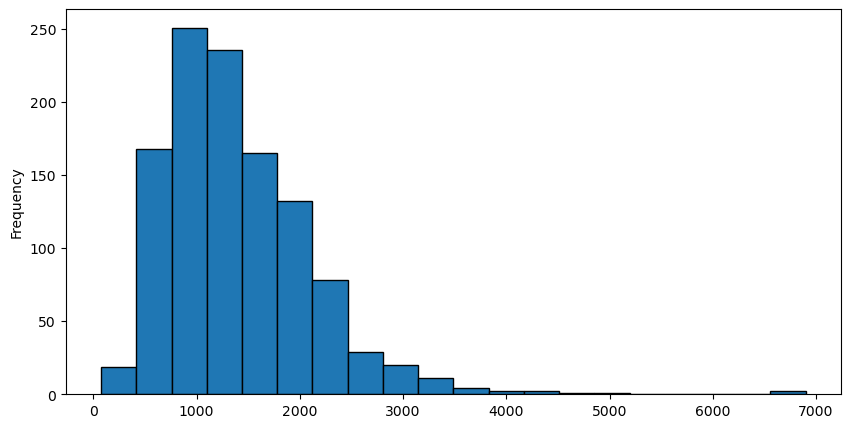

Estimated Personal Cost outliers: 24
Outlier Upper bound: 3135.0
Outlier Lower bound: -441.0
Q1: 900.0
Q2: 1250.0
Q3: 1794.0
Mean: 1389.2917038358607
Standard Deviation: 714.2478571476715
Variance: 510150.00144004065
Min: 75.0, Max: 6900.0
Skewness: 1.7168252905840495
Kurtosis: 7.062689436249425


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Prescott College,AZ,2,321.0,227.0,129.0,NaN,NaN,693.0,40.0,9800.0,...,55.0,2.3,NaN,34.544894,-112.477498,Yavapai County,Prescott College,"Elm Street, Prescott, AZ 86313, United States ...",86313,West
California Institute of Technology,CA,2,1916.0,507.0,210.0,98.0,100.0,912.0,NaN,16695.0,...,100.0,6.5,83.0,34.137014,-118.125288,Los Angeles County,California Institute of Technology,"San Pasqual Street, Pasadena, CA 91125, United...",91125,West
Colorado Christian University,CO,2,735.0,583.0,310.0,9.0,NaN,1001.0,65.0,6720.0,...,56.0,8.6,NaN,39.092259,-108.598444,Mesa County,Colorado Christian University,"2452 Patterson Road, Grand Junction, CO 81505,...",81505,West
Nova Southeastern University,FL,2,1025.0,770.0,257.0,NaN,NaN,1893.0,1220.0,8550.0,...,90.0,20.4,23.0,26.080089,-80.248547,Broward County,Nova Southeastern University,"Davie, FL 33328, United States of America",33328,South
Georgia State University,GA,1,3793.0,2341.0,1238.0,9.0,24.0,7732.0,9054.0,2154.0,...,87.0,19.0,34.0,33.753589,-84.385421,Fulton County,Georgia State University,"33 Gilmer Street Southeast, Atlanta, GA 30303,...",30303,South
Oglethorpe University,GA,2,792.0,649.0,186.0,56.0,87.0,769.0,377.0,12900.0,...,91.0,13.1,67.0,34.486249,-84.331428,Pickens County,Mount Oglethorpe,"Pickens County, GA, United States of America",NaN,South
University of Illinois at Chicago,IL,1,8384.0,5727.0,2710.0,22.0,50.0,13518.0,2916.0,2520.0,...,82.0,10.0,34.0,41.868922,-87.648585,Cook County,University of Illinois at Chicago,"1200 West Harrison Street, Chicago, IL 60607, ...",60607,Midwest
MidAmerica Nazarene College,KS,2,331.0,331.0,225.0,15.0,36.0,1100.0,166.0,6840.0,...,33.0,15.4,49.0,38.873971,-94.782190,Johnson County,MidAmerica Nazarene University,"South Winterbrook Drive, Olathe, KS 66062, Uni...",66062,Midwest
Lindenwood College,MO,2,810.0,484.0,356.0,6.0,33.0,2155.0,191.0,9200.0,...,65.0,24.1,100.0,41.079803,-85.175557,Allen County,Lindenwood Cemetery,"Fort Wayne, IN, United States of America",NaN,Midwest


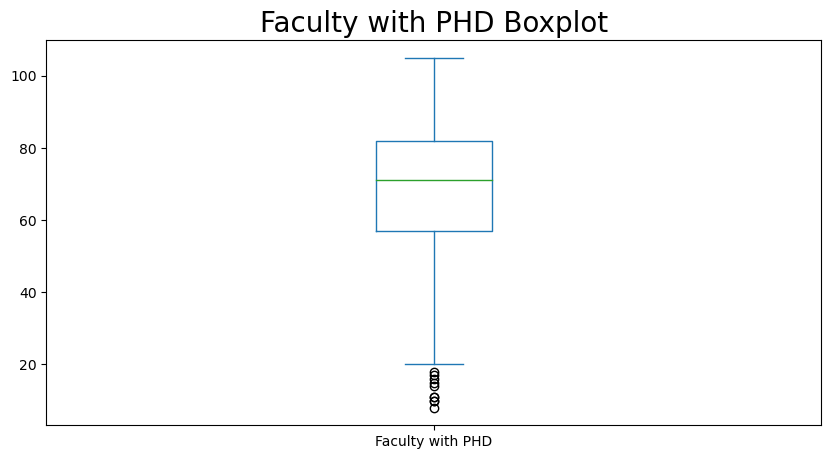

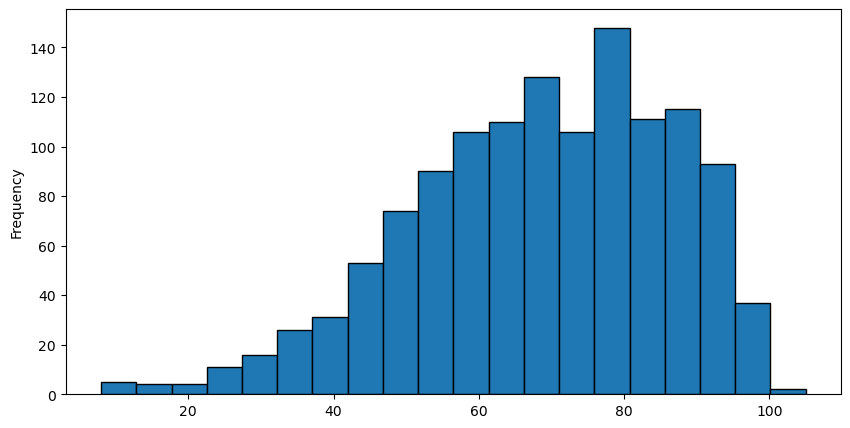

Faculty with PHD outliers: 10
Outlier Upper bound: 119.5
Outlier Lower bound: 19.5
Q1: 57.0
Q2: 71.0
Q3: 82.0
Mean: 68.64566929133858
Standard Deviation: 17.825627490065532
Variance: 317.75299541457997
Min: 8.0, Max: 105.0
Skewness: -0.5178719086140421
Kurtosis: -0.11751018101006183


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Savannah Coll. of Art and Design,GA,2,1109.0,688.0,386.0,20.0,65.0,1897.0,208.0,8325.0,...,14.0,16.1,55.0,32.083645,-81.148434,Chatham County,Savannah,"Seaboard Coastline Drive, Savannah, GA 31415, ...",31415,South
Columbia College,IL,2,2419.0,2160.0,1117.0,NaN,NaN,4852.0,1991.0,7310.0,...,18.0,13.4,41.0,41.875395,-87.626504,Cook County,Columbia College,"33 East Ida B. Wells Drive, Chicago, IL 60605,...",60605,Midwest
Berklee College of Music,MA,2,1975.0,1516.0,712.0,NaN,NaN,2223.0,304.0,11550.0,...,15.0,10.2,38.0,42.346723,-71.086976,Suffolk County,Berklee College of Music,"138 Massachusetts Avenue, Boston, MA 02115, Un...",02115,North
Wentworth Institute of Technology,MA,2,1480.0,1257.0,452.0,6.0,25.0,2961.0,572.0,9850.0,...,10.0,15.4,64.0,42.336593,-71.095360,Suffolk County,Wentworth Institute of Technology,"Ruggles Street, Boston, MA 02115, United State...",02115,North
Capitol College,MD,2,100.0,90.0,35.0,10.0,52.0,282.0,331.0,8400.0,...,10.0,12.1,52.0,39.047340,-76.851100,Prince George's County,Capitol College,"South Laurel, MD, United States of America",NaN,North
Baker College of Flint,MI,2,1754.0,1754.0,1171.0,NaN,NaN,2805.0,1342.0,5760.0,...,11.0,38.2,NaN,42.976317,-83.696586,Genesee County,Baker College,"1050 West Bristol Road, Flint, MI 48507, Unite...",48507,Midwest
Center for Creative Studies,MI,2,601.0,396.0,203.0,1.0,20.0,525.0,323.0,11230.0,...,8.0,6.8,47.0,42.242027,-83.561771,Washtenaw County,American Center for Mobility Access,"Ypsilanti, MI, United States of America",NaN,Midwest
Art Academy of Cincinnati,OH,2,130.0,82.0,33.0,NaN,NaN,199.0,31.0,8450.0,...,11.0,7.5,NaN,39.108894,-84.513868,Hamilton County,The Art Academy of Cincinnati,"Rodney Alley, Cincinnati, OH 45202, United Sta...",45202,Midwest
Lourdes College,OH,2,57.0,55.0,32.0,17.0,48.0,435.0,1174.0,6992.0,...,17.0,9.6,46.0,39.217670,-84.551670,Hamilton County,"North College Hill, OH",United States of America,NaN,Midwest


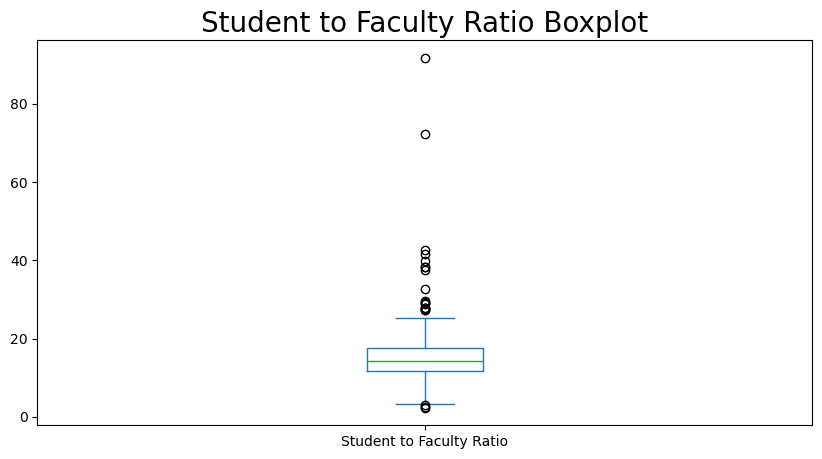

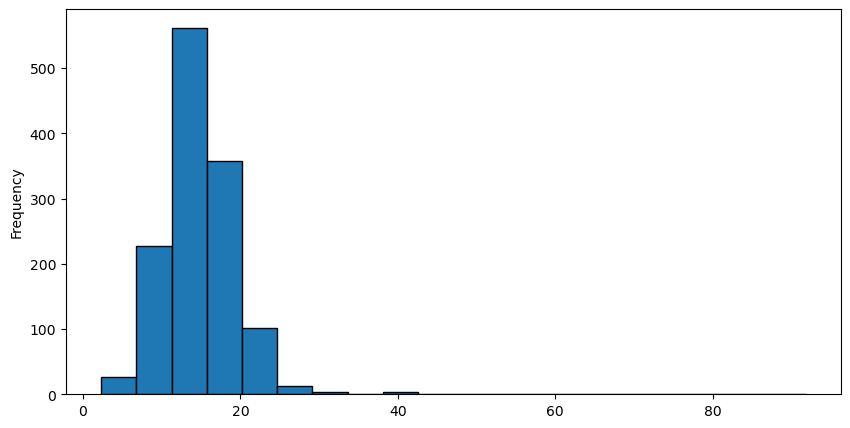

Student to Faculty Ratio outliers: 22
Outlier Upper bound: 26.300000000000004
Outlier Lower bound: 3.0999999999999996
Q1: 11.8
Q2: 14.3
Q3: 17.6
Mean: 14.858769230769232
Standard Deviation: 5.186398540011623
Variance: 26.898729815834688
Min: 2.3, Max: 91.8
Skewness: 4.185758980392306
Kurtosis: 50.07915787245135


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Faulkner University,AL,2,345.0,320.0,179.0,NaN,27.0,1367.0,578.0,5600.0,...,52.0,32.8,55.0,32.385478,-86.217106,Montgomery County,Faulkner University,"5345 Atlanta Highway, Montgomery, AL 36109, Un...",36109,South
University of Arkansas at Monticello,AR,1,826.0,794.0,662.0,NaN,NaN,4539.0,357.0,1536.0,...,54.0,42.6,NaN,33.590387,-91.813187,Drew County,University of Arkansas at Monticello,"University Drive, Monticello, AR 71655, United...",71655,South
Prescott College,AZ,2,321.0,227.0,129.0,NaN,NaN,693.0,40.0,9800.0,...,55.0,2.3,NaN,34.544894,-112.477498,Yavapai County,Prescott College,"Elm Street, Prescott, AZ 86313, United States ...",86313,West
Adams State College,CO,1,1508.0,1259.0,569.0,16.0,44.0,1922.0,232.0,1386.0,...,63.0,27.9,60.0,37.475029,-105.880287,Alamosa County,Adams State University,"Alamosa, CO, United States of America",NaN,West
Mesa State College,CO,1,1584.0,1456.0,891.0,6.0,18.0,3471.0,911.0,1434.0,...,48.0,28.8,59.0,37.288201,-107.863313,La Plata County,College Mesa,"Durango, CO, United States of America",NaN,West
Goldey Beacom College,DE,2,633.0,468.0,284.0,10.0,27.0,823.0,963.0,6120.0,...,25.0,27.6,36.0,39.741126,-75.688971,New Castle County,Goldey-Beacom College,"Stoney Batter Road, Mermaid, DE 19707, United ...",19707,North
St. Leo College,FL,2,990.0,683.0,201.0,NaN,NaN,3400.0,3731.0,9150.0,...,47.0,72.4,NaN,28.338539,-82.258071,Pasco County,Saint Leo University,"33701 Priory Circle, Saint Leo, FL 33576, Unit...",33576,South
Indiana Wesleyan University,IN,2,735.0,423.0,366.0,20.0,48.0,2448.0,707.0,9210.0,...,49.0,39.8,34.0,40.516427,-85.664116,Grant County,Indiana Wesleyan University,"South Colonial Oaks Drive, Marion, IN 46953, U...",46953,Midwest
Northwestern State University of Louisiana,LA,1,2671.0,2671.0,1330.0,NaN,NaN,5742.0,1969.0,2040.0,...,67.0,29.5,33.0,42.055716,-87.675295,Cook County,Northwestern University,"633 Clark Street, Evanston, IL 60208, United S...",60208,South


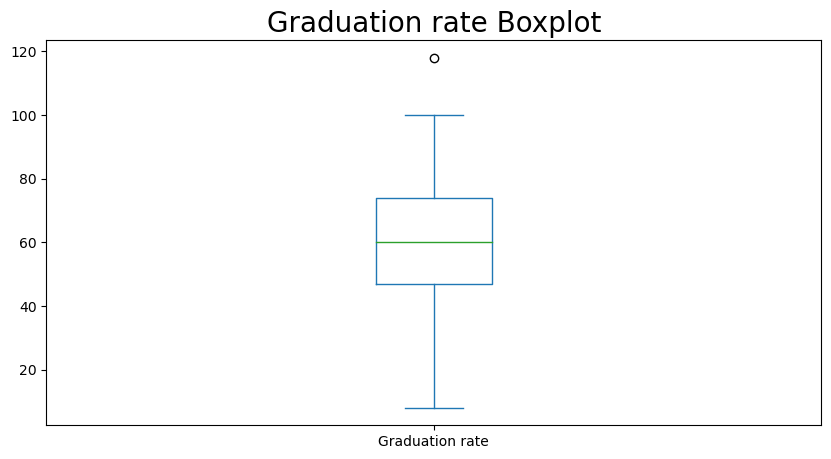

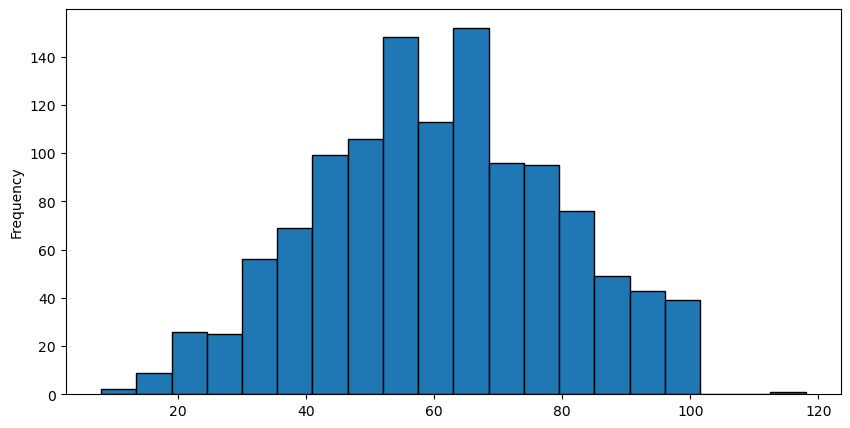

Graduation rate outliers: 1
Outlier Upper bound: 114.5
Outlier Lower bound: 6.5
Q1: 47.0
Q2: 60.0
Q3: 74.0
Mean: 60.40531561461794
Standard Deviation: 18.88905804160549
Variance: 356.79651369914103
Min: 8.0, Max: 118.0
Skewness: 0.002852357205432208
Kurtosis: -0.4524129601238136


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Cazenovia College,NY,2,3847.0,3433.0,527.0,9.0,35.0,1010.0,12.0,9384.0,...,22.0,14.3,118.0,42.93222,-75.85361,Madison County,Cazenovia College,"Village of Cazenovia, NY, United States of Ame...",NaN,North


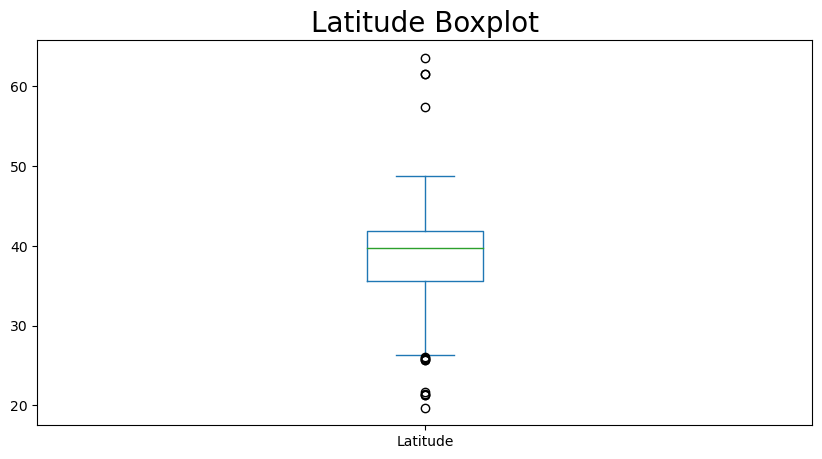

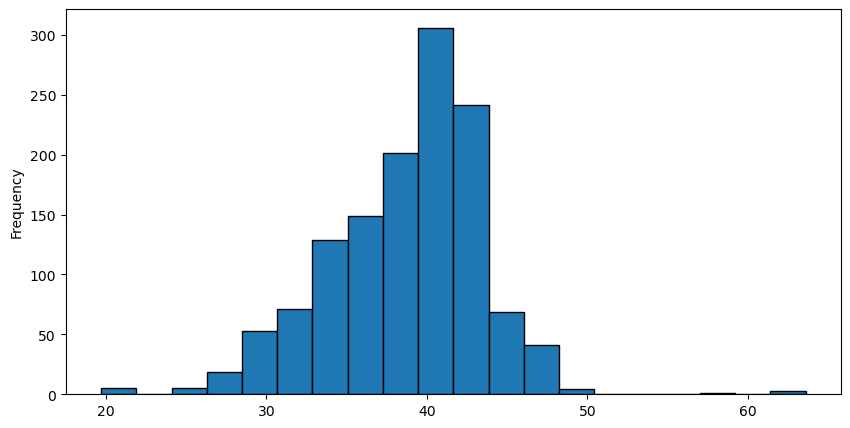

Latitude outliers: 14
Outlier Upper bound: 51.28283300000001
Outlier Lower bound: 26.27775779999999
Q1: 35.654661
Q2: 39.6803338
Q3: 41.9059298
Mean: 38.74366119552814
Standard Deviation: 4.7008571859384904
Variance: 22.098058282589545
Min: 19.704397, Max: 63.599624
Skewness: -0.26698645042276914
Kurtosis: 1.61227770201323


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Alaska Pacific University,AK,2,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,...,76.0,11.9,15.0,57.440798,-152.354501,Kodiak Island Borough,Pacific Spaceport Complex Alaska,"Kodiak Island Borough, AK, United States of Am...",NaN,West
University of Alaska at Fairbanks,AK,1,1852.0,1427.0,928.0,NaN,NaN,3885.0,4519.0,1742.0,...,67.0,10.0,NaN,61.563915,-149.229834,Matanuska-Susitna,University of Alaska Fairbanks Experimental Fa...,"Monitor Well Jeep Road, Matanuska-Susitna, AK,...",NaN,West
University of Alaska Southeast,AK,1,146.0,117.0,89.0,4.0,24.0,492.0,1849.0,1742.0,...,39.0,9.5,39.0,61.566670,-149.250830,Matanuska-Susitna Borough,University of Alaska Experimental Farm,"Gateway, AK, United States of America",NaN,West
Barry University,FL,2,990.0,784.0,279.0,18.0,45.0,1811.0,3144.0,11290.0,...,76.0,12.6,72.0,25.879029,-80.201517,Miami-Dade County,Barry University,"11300 Northeast 2nd Avenue, Miami Shores, FL 3...",33161,South
St. Thomas University,FL,2,492.0,370.0,236.0,10.0,30.0,1125.0,482.0,9600.0,...,NaN,23.2,33.0,25.734167,-80.369722,Miami-Dade County,Saint Thomas Academy,"Southwest 108th Avenue, University Park, FL 33...",33165,South
Florida Memorial College,FL,2,2400.0,1800.0,557.0,NaN,NaN,1312.0,176.0,4160.0,...,38.0,17.1,35.0,25.916483,-80.269216,Miami-Dade County,Florida Memorial College,"15800 Northwest 156th Street, Miami Gardens, F...",33054,South
Nova Southeastern University,FL,2,1025.0,770.0,257.0,NaN,NaN,1893.0,1220.0,8550.0,...,90.0,20.4,23.0,26.080089,-80.248547,Broward County,Nova Southeastern University,"Davie, FL 33328, United States of America",33328,South
University of Miami,FL,2,7122.0,5386.0,1643.0,42.0,69.0,7760.0,876.0,16500.0,...,82.0,5.9,59.0,25.737880,-80.278940,Miami-Dade County,University of Miami,"Ludlum, Coral Gables, FL, United States of Ame...",NaN,South
Chaminade University of Honolulu,HI,2,621.0,546.0,103.0,NaN,NaN,766.0,1154.0,10600.0,...,63.0,14.1,NaN,21.297933,-157.822486,Honolulu County,University Laboratory School,"Hoonanea Street, Honolulu, HI 96826, United St...",96826,West


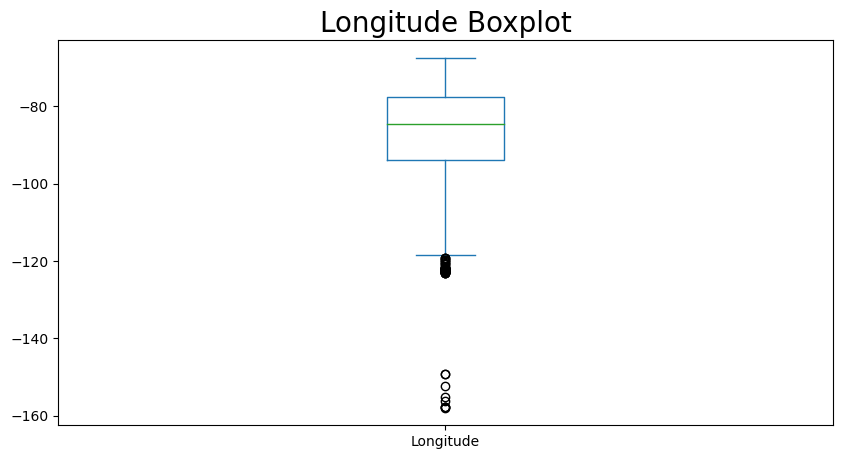

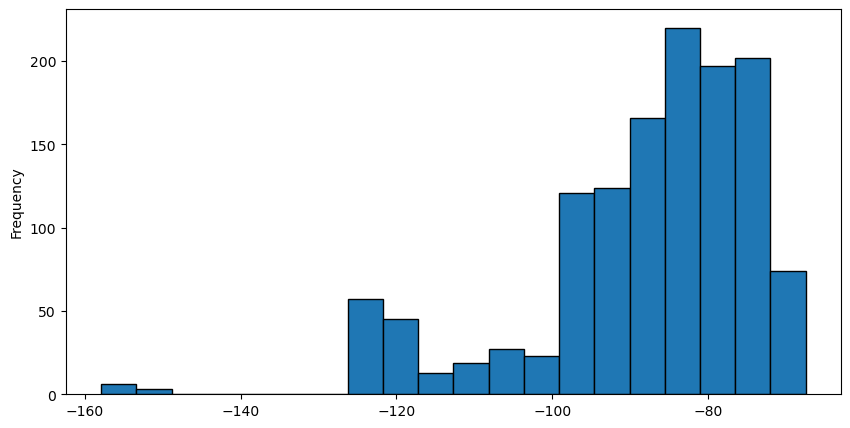

Longitude outliers: 78
Outlier Upper bound: -52.799896301625566
Outlier Lower bound: -118.71646616395738
Q1: -93.99775246558295
Q2: -84.49398715778406
Q3: -77.51861
Mean: -88.09496724083884
Standard Deviation: 14.62957782489034
Variance: 214.0245473345232
Min: -157.9259550896773, Max: -67.45654323568989
Skewness: -1.471723858189841
Kurtosis: 2.6226696809929133


,State,Public/Private,Applicantions Received,Applications Accepted,New Students Enrolled,% New Students from Top 10%,% New Students from Top 25%,# FT undergrad,# PT undergrad,in-state tuition,...,Faculty with PHD,Student to Faculty Ratio,Graduation rate,Latitude,Longitude,County,Address1,Address2,Zip Code,Region
College Name,,,,,,,,,,,,,,,,,,,,,
Alaska Pacific University,AK,2,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,...,76.0,11.9,15.0,57.440798,-152.354501,Kodiak Island Borough,Pacific Spaceport Complex Alaska,"Kodiak Island Borough, AK, United States of Am...",NaN,West
University of Alaska at Fairbanks,AK,1,1852.0,1427.0,928.0,NaN,NaN,3885.0,4519.0,1742.0,...,67.0,10.0,NaN,61.563915,-149.229834,Matanuska-Susitna,University of Alaska Fairbanks Experimental Fa...,"Monitor Well Jeep Road, Matanuska-Susitna, AK,...",NaN,West
University of Alaska Southeast,AK,1,146.0,117.0,89.0,4.0,24.0,492.0,1849.0,1742.0,...,39.0,9.5,39.0,61.566670,-149.250830,Matanuska-Susitna Borough,University of Alaska Experimental Farm,"Gateway, AK, United States of America",NaN,West
Azusa Pacific University,CA,2,1080.0,948.0,504.0,25.0,56.0,2032.0,122.0,15500.0,...,47.0,12.8,NaN,36.992476,-122.058858,Santa Cruz County,University,"Santa Cruz, CA, United States of America",95064,West
Biola University,CA,2,1118.0,896.0,459.0,NaN,NaN,2058.0,111.0,11388.0,...,67.0,16.6,36.0,37.000881,-122.058056,Santa Cruz County,University Center,"Santa Cruz, CA 95064, United States of America",95064,West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
University of Puget Sound,WA,2,4044.0,2826.0,688.0,51.0,83.0,2738.0,138.0,16230.0,...,79.0,15.0,63.0,47.261593,-122.481090,Pierce County,University of Puget Sound,"1500 North Warner Street, Tacoma, WA 98416, Un...",98416,West
University of Washington,WA,1,12749.0,7025.0,3343.0,40.0,81.0,20356.0,4582.0,2907.0,...,96.0,9.0,65.0,47.654347,-122.308061,King County,University of Washington,"Burke-Gilman Trail, Seattle, WA 98105, United ...",98105,West
Western Washington University,WA,1,5548.0,3563.0,1549.0,30.0,71.0,8909.0,506.0,2406.0,...,83.0,22.7,61.0,48.734141,-122.487464,Whatcom County,Western Washington University,"516 High Street, Bellingham, WA 98225, United ...",98225,West


In [11]:
for col in college_df.columns:
    if college_df[col].dtype != 'object':
        college_df[col].plot(kind='box', figsize=(10, 5))
        plt.title(f'{col} Boxplot', size=20)
        plt.show()
        lower,upper, q1,q3,q2 = IQR_outlier_report(college_df[col])    
        
        college_df[col].plot(kind='hist', figsize=(10, 5), edgecolor='black', bins=20)
        plt.show()
        
        print(f"{col} outliers: {college_df[(college_df[col] < lower) | (college_df[col] > upper)].shape[0]}")
        print(f'Outlier Upper bound: {upper}')
        print(f'Outlier Lower bound: {lower}')
        print(f'Q1: {q1}')
        print(f'Q2: {q2}')
        print(f'Q3: {q3}')
        print(f'Mean: {college_df[col].mean()}')
        print(f'Standard Deviation: {college_df[col].std()}')
        print(f'Variance: {college_df[col].var()}')
        print(f'Min: {college_df[col].min()}, Max: {college_df[col].max()}')
        print(f'Skewness: {college_df[col].skew()}')
        print(f'Kurtosis: {college_df[col].kurtosis()}')
        display(college_df[ (college_df[col] > upper) | (college_df[col] < lower)])
        
        


In [12]:
#2016 Actual Graduation is 43% for Cazenovia College, 120 is a lie
college_df.loc['Cazenovia College','Graduation rate'] = 43 

In [13]:
#fixing DC region to North
college_df.loc[college_df['State'] == 'DC','Region']='North'

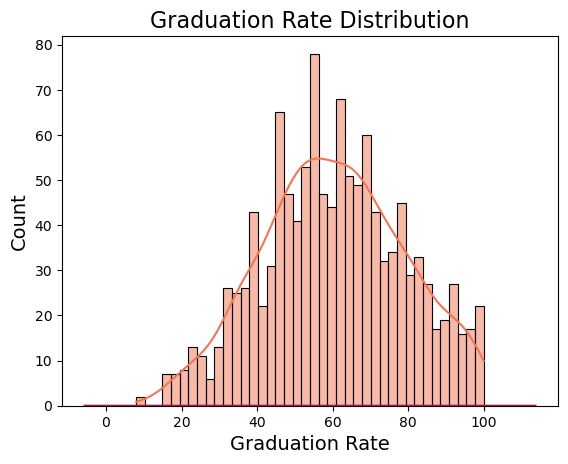

ShapiroResult(statistic=0.992694079875946, pvalue=1.1488695236039348e-05)
count    1204.000000
mean       60.343023
std        18.822515
min         8.000000
25%        47.000000
50%        60.000000
75%        74.000000
max       100.000000
Name: Graduation rate, dtype: float64


In [14]:
from scipy.stats import shapiro,kstest

grad_clean_college_df = college_df.dropna(subset=['Graduation rate'])

sns.histplot(x='Graduation rate', bins=40, color='#f37651', data=grad_clean_college_df, kde=True)
sns.kdeplot(x='Graduation rate', data=grad_clean_college_df, color='#ad1759')
#cleaning Data for graduation rate
grad_clean_college_df = college_df.dropna(subset=['Graduation rate'])

plt.title(label='Graduation Rate Distribution', fontsize=16)
plt.xlabel('Graduation Rate', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.savefig('images/graduation_rate_distribution.png', bbox_inches='tight')
plt.show()
print(shapiro(grad_clean_college_df['Graduation rate']))
print(grad_clean_college_df['Graduation rate'].describe())

In [15]:
college=[print(x) for x in grad_clean_college_df[grad_clean_college_df['Graduation rate'] == grad_clean_college_df['Graduation rate'].max()].reset_index()['College Name']]
college

Harvey Mudd College
Santa Clara University
Amherst College
Harvard University
Lindenwood College
Missouri Southern State College
Siena College
College of Mount St. Joseph
Grove City College
University of Richmond
Goddard College
Heritage College


[None, None, None, None, None, None, None, None, None, None, None, None]

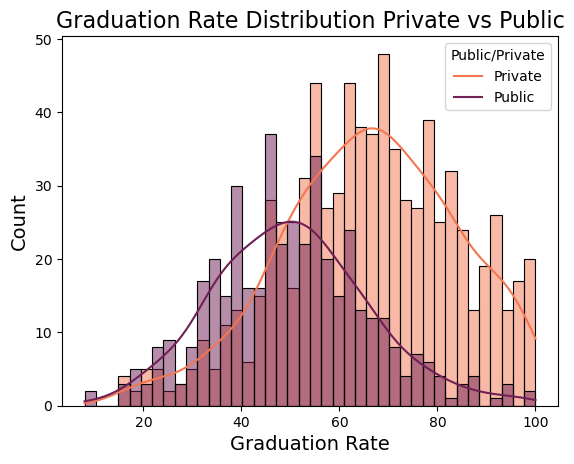

In [16]:
from scipy.stats import shapiro,kstest



custom_palette = {
    1: '#701f57',  # Color for Category A
    2: '#f37651'   # Color for Category B
}

#cleaning Data for graduation rate
grad_clean_college_df = college_df.dropna(subset=['Graduation rate'])

sns.histplot(x='Graduation rate', bins=40, color='#ad1759', data=grad_clean_college_df, kde=True, hue='Public/Private',palette=custom_palette)
plt.title(label='Graduation Rate Distribution Private vs Public', fontsize=16)
plt.xlabel('Graduation Rate', fontsize=14)
plt.ylabel('Count', fontsize=14)
new_labels = ['Private', 'Public']
plt.legend(title='Public/Private', labels=new_labels)
plt.savefig('images/graduation_rate_distribution_private_public.png', bbox_inches='tight')
plt.show()


In [17]:
print(grad_clean_college_df.groupby('Public/Private')['Graduation rate'].mean())
private_grad = grad_clean_college_df[grad_clean_college_df['Public/Private'] == 2]['Graduation rate']
public_grad = grad_clean_college_df[grad_clean_college_df['Public/Private'] == 1]['Graduation rate']
print(round(ttest_ind(private_grad, public_grad, equal_var=False).pvalue, 2))
print(round(ttest_ind(private_grad, public_grad, equal_var=False).statistic, 2))


Public/Private
1    50.182028
2    66.070130
Name: Graduation rate, dtype: float64
0.0
15.93


Mean per Region
 ------------------
 Region
Midwest    60.954268
North      68.937143
South      53.710875
West       55.590604
Name: Graduation rate, dtype: float64
fvalue=48.301367314449074, pvalue=1.7985197246630682e-29
Ttest_indResult(statistic=1.0581497439139216, pvalue=0.2909239723317699)
Ttest_indResult(statistic=3.0207147391578335, pvalue=0.0027636947332921745)
Ttest_indResult(statistic=5.998630345632041, pvalue=3.245292213168624e-09)


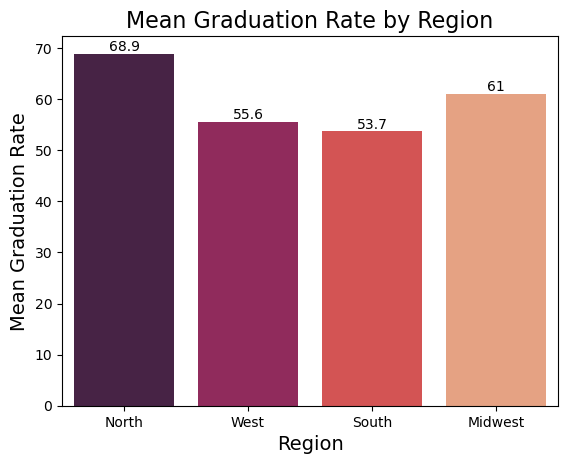

In [18]:
print(f"Mean per Region\n ------------------\n {grad_clean_college_df.groupby('Region')['Graduation rate'].mean()}")
North = grad_clean_college_df[grad_clean_college_df['Region'] == 'North']['Graduation rate']
West = grad_clean_college_df[grad_clean_college_df['Region'] == 'West']['Graduation rate']
South = grad_clean_college_df[grad_clean_college_df['Region'] == 'South']['Graduation rate']
Midwest = grad_clean_college_df[grad_clean_college_df['Region'] == 'Midwest']['Graduation rate']
fvalue, pvalue = stats.f_oneway(North, West, South, Midwest)
print(f'fvalue={fvalue}, pvalue={pvalue}')

print(ttest_ind(West,South, equal_var=False))
print(ttest_ind(Midwest,West, equal_var=False))
print(ttest_ind(North,Midwest, equal_var=False))


means=[round(North.mean(),1), 
       round(West.mean(),1),
       round(South.mean(),1),
       round(Midwest.mean(),1)]
ax = sns.barplot(x=['North', 'West', 'South', 'Midwest'], y=means, palette='rocket', )
plt.title('Mean Graduation Rate by Region', fontsize=16)
plt.ylabel('Mean Graduation Rate', fontsize=14)
plt.xlabel('Region',fontsize=14)
for i in ax.containers:
    ax.bar_label(i,)

plt.savefig('images/mean_graduation_rate_by_region.png', bbox_inches='tight')
plt.show()





1302
1176


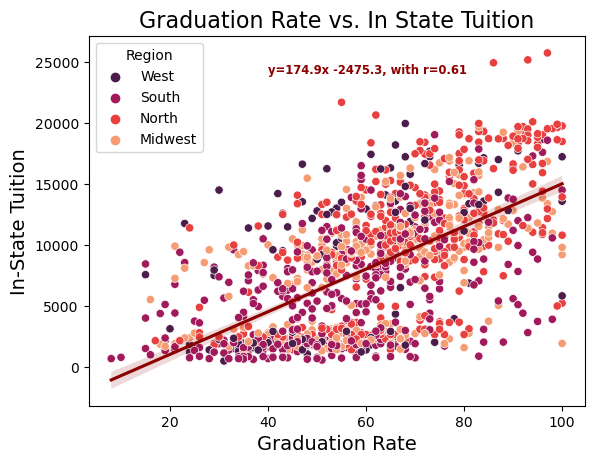

In [19]:
print(len(college_df))

in_state_tuition_grad_df = grad_clean_college_df.dropna(subset=['in-state tuition', 'Graduation rate'], how='any')

print(len(in_state_tuition_grad_df))

sns.scatterplot(x=in_state_tuition_grad_df['Graduation rate'], y=in_state_tuition_grad_df['in-state tuition'], hue=in_state_tuition_grad_df['Region'], palette='rocket')

#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=in_state_tuition_grad_df['Graduation rate'], \
    y=in_state_tuition_grad_df['in-state tuition'])

equation =  f"y={round(slope,2)}x {round(intercept,2)}, with r={round(r,2)}"

sns.regplot(x = in_state_tuition_grad_df['Graduation rate'], y = in_state_tuition_grad_df['in-state tuition'], scatter=False, color='darkred')
plt.text(40, 24000, equation, horizontalalignment='left', size='small', color='darkred', weight='semibold')
plt.title('Graduation Rate vs. In State Tuition', fontsize=16)
plt.xlabel('Graduation Rate', fontsize=14)
plt.ylabel('In-State Tuition', fontsize=14)
plt.savefig('images/in-state-tuition-vs-graduation-rates_regression_region.png')
plt.show()

139.93230670374916


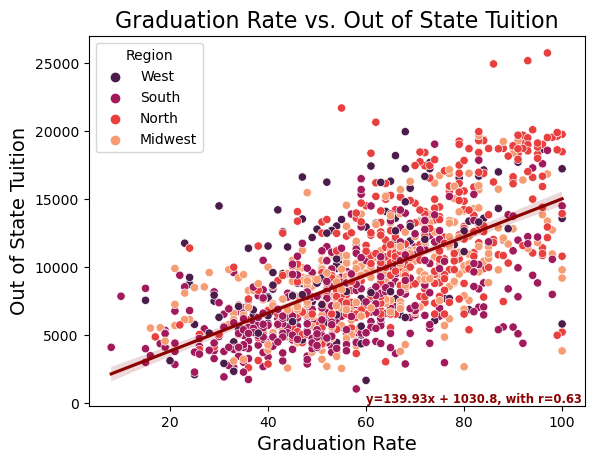

In [20]:

gradution_clean_df = grad_clean_college_df.dropna(subset=['Graduation rate', 'out-of-state tuition'], how='any')
sns.scatterplot(x=gradution_clean_df['Graduation rate'], y=gradution_clean_df['out-of-state tuition'], hue=gradution_clean_df['Region'], palette='rocket')


#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=gradution_clean_df['Graduation rate'], \
    y=gradution_clean_df['out-of-state tuition'])
print(slope)

equation =  f"y={round(slope,2)}x + {round(intercept,2)}, with r={round(r,2)}"

sns.regplot(x = gradution_clean_df['Graduation rate'], y = gradution_clean_df['out-of-state tuition'], scatter=False, color='darkred')
plt.text(60, 20, equation, horizontalalignment='left', size='small', color='darkred', weight='semibold')
plt.title('Graduation Rate vs. Out of State Tuition', fontsize=16)
plt.xlabel('Graduation Rate', fontsize=14)
plt.ylabel('Out of State Tuition', fontsize=14)
plt.savefig('images/out-of-state-tuition-vs-graduation-rates_regression_region.png')
plt.show()

In [21]:
print(college_df.groupby('Region')['State'].count())

Region
Midwest    352
North      372
South      410
West       168
Name: State, dtype: int64


In [22]:
print(college_df.groupby('State')['State'].count())

State
AK      4
AL     25
AR     17
AZ      5
CA     70
CO     16
CT     19
DC      9
DE      5
FL     30
GA     36
HI      5
IA     29
ID      6
IL     49
IN     42
KS     20
KY     24
LA     20
MA     56
MD     23
ME     14
MI     36
MN     25
MO     35
MS     15
MT      9
NC     46
ND      8
NE     16
NH     13
NJ     27
NM      9
NV      3
NY    101
OH     52
OK     20
OR     18
PA     83
RI      8
SC     26
SD     11
TN     34
TX     60
UT      6
VA     40
VT     14
WA     16
WI     29
WV     17
WY      1
Name: State, dtype: int64


In [23]:
import geopandas as gpd

url = 'https://raw.githubusercontent.com/jcanalesluna/bcn-geodata/master/districtes/districtes.geojson'
states = geopandas.read_file

-1.6313556075413693


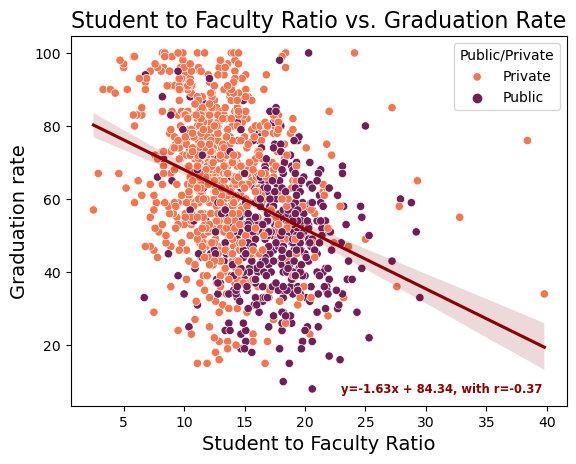

In [24]:
clean_grad_faculty = college_df.dropna(subset=['Student to Faculty Ratio', 'Graduation rate'], how='any')
gradution_clean_df = grad_clean_college_df.dropna(subset=['Student to Faculty Ratio','Graduation rate'], how='any')

#
gradution_clean_df = gradution_clean_df[ gradution_clean_df['Student to Faculty Ratio'] < gradution_clean_df['Student to Faculty Ratio'].max()]


sns.scatterplot(x='Student to Faculty Ratio', y='Graduation rate', data=gradution_clean_df, palette=custom_palette, hue='Public/Private')


custom_palette = {
    1: '#701f57',  # Color for Category A
    2: '#f37651'   # Color for Category B
}

#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=gradution_clean_df['Student to Faculty Ratio'], \
    y=gradution_clean_df['Graduation rate'])
print(slope)

equation =  f"y={round(slope,2)}x + {round(intercept,2)}, with r={round(r,2)}"

sns.regplot(x = gradution_clean_df['Student to Faculty Ratio'], y = gradution_clean_df['Graduation rate'], scatter=False, color='darkred')
plt.text(23, 7, equation, horizontalalignment='left', size='small', color='darkred', weight='semibold')
plt.title('Student to Faculty Ratio vs. Graduation Rate', fontsize=16)
plt.xlabel('Student to Faculty Ratio', fontsize=14)
plt.ylabel('Graduation rate', fontsize=14)
new_labels = ['Private', 'Public']
plt.legend(title='Public/Private', labels=new_labels)
plt.savefig('images/student_to_faculty_ratio-graduation-rates.png')
plt.show()

In [25]:
print(gradution_clean_df.groupby('Public/Private')['Student to Faculty Ratio'].mean())

private_grad = gradution_clean_df[gradution_clean_df['Public/Private'] == 2]['Student to Faculty Ratio']
public_grad = gradution_clean_df[gradution_clean_df['Public/Private'] == 1]['Student to Faculty Ratio']
print(ttest_ind(private_grad, public_grad, equal_var=False))



Public/Private
1    17.442396
2    13.148505
Name: Student to Faculty Ratio, dtype: float64
Ttest_indResult(statistic=-19.778141988804926, pvalue=3.4902379057108977e-73)


In [26]:
college_df.columns

Index(['State', 'Public/Private', 'Applicantions Received',
       'Applications Accepted', 'New Students Enrolled',
       '% New Students from Top 10%', '% New Students from Top 25%',
       '# FT undergrad', '# PT undergrad', 'in-state tuition',
       'out-of-state tuition', 'room', 'board', 'add. fees',
       'estim. book costs', 'Estimated Personal Cost', 'Faculty with PHD',
       'Student to Faculty Ratio', 'Graduation rate', 'Latitude', 'Longitude',
       'County', 'Address1', 'Address2', 'Zip Code', 'Region'],
      dtype='object')

## COST

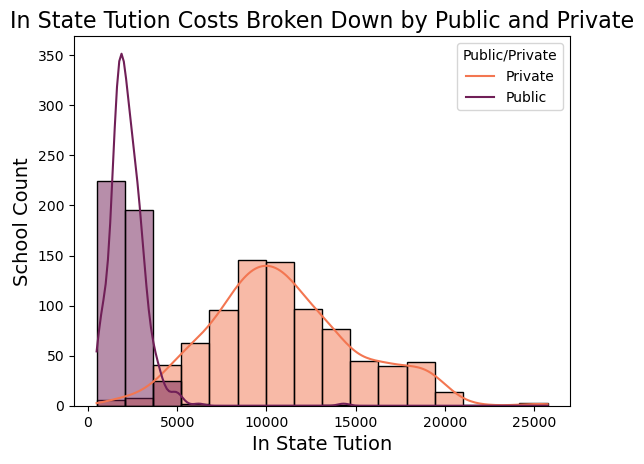

Bin Edges: [  480.   1743.5  3007.   4270.5  5534.   6797.5  8061.   9324.5 10588.
 11851.5 13115.  14378.5 15642.  16905.5 18169.  19432.5 20696.  21959.5
 23223.  24486.5 25750. ]
Bin Sizes: [1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5
 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5 1263.5]
Ttest_indResult(statistic=58.63075249560053, pvalue=0.0)
Middlebury College, Bates College, Franklin and Marshall College, Bennington College, Hampshire College, Massachusetts Institute of Technology


In [27]:
clean_intution_df = college_df.dropna(subset=['in-state tuition'])
sns.histplot(x='in-state tuition',data=clean_intution_df,bins="auto", kde=True, hue="Public/Private", palette=custom_palette)

counts, bin_edges = np.histogram(clean_intution_df['in-state tuition'], bins=20)
bin_sizes = np.diff(bin_edges)

plt.title('In State Tution Costs Broken Down by Public and Private', fontsize=16)
plt.xlabel('In State Tution', fontsize=14)
plt.ylabel('School Count', fontsize=14)
new_labels = ['Private', 'Public']
plt.legend(title='Public/Private', labels=new_labels)
plt.savefig('images/in-state-tuition_distribution_public_private.png')
plt.show()


print("Bin Edges:", bin_edges)
print("Bin Sizes:", bin_sizes)

col_list=clean_intution_df[clean_intution_df['in-state tuition'] >= 20000].sort_values(by='in-state tuition', ascending=False).reset_index()['College Name']
s=', '.join(col_list)

private_cost = clean_intution_df[clean_intution_df['Public/Private'] == 2]['in-state tuition']
public_cost = clean_intution_df[clean_intution_df['Public/Private'] == 1]['in-state tuition']
ttest_ind(private_cost, public_cost, equal_var=False)
print(ttest_ind(list(private_cost), list(public_cost), equal_var=False))

s=', '.join(col_list)
print(s)

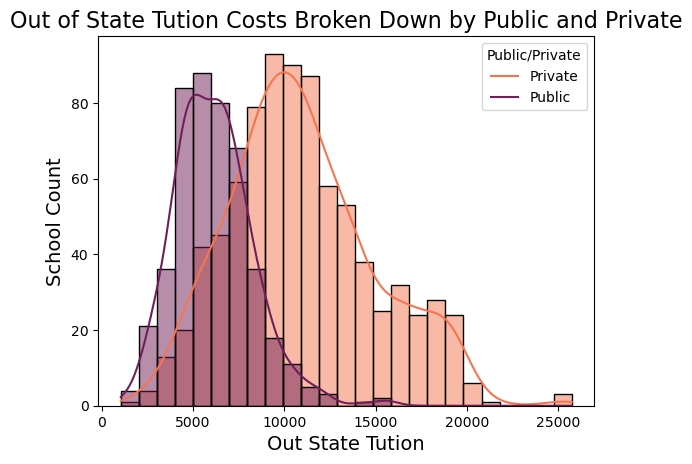

Bin Edges: [ 1044.   2279.3  3514.6  4749.9  5985.2  7220.5  8455.8  9691.1 10926.4
 12161.7 13397.  14632.3 15867.6 17102.9 18338.2 19573.5 20808.8 22044.1
 23279.4 24514.7 25750. ]
Bin Sizes: [1235.3 1235.3 1235.3 1235.3 1235.3 1235.3 1235.3 1235.3 1235.3 1235.3
 1235.3 1235.3 1235.3 1235.3 1235.3 1235.3 1235.3 1235.3 1235.3 1235.3]
Ttest_indResult(statistic=28.265270726120086, pvalue=6.13897834846287e-137)
6151.630196936542
Middlebury College, Bates College, Franklin and Marshall College, Bennington College, Hampshire College, Massachusetts Institute of Technology


In [28]:
clean_out_df = college_df.dropna(subset=['out-of-state tuition'])
sns.histplot(x='out-of-state tuition',data=clean_out_df,bins="auto", kde=True, hue="Public/Private", palette=custom_palette)

plt.figsize=(20,10)
counts, bin_edges = np.histogram(clean_out_df['out-of-state tuition'], bins=20)
bin_sizes = np.diff(bin_edges)

plt.title('Out of State Tution Costs Broken Down by Public and Private', fontsize=16)
plt.xlabel('Out State Tution', fontsize=14)
plt.ylabel('School Count', fontsize=14)
new_labels = ['Private', 'Public']
plt.legend(title='Public/Private', labels=new_labels)
plt.savefig('images/out-state-tuition_distribution_public_private.png')
plt.show()


print("Bin Edges:", bin_edges)
print("Bin Sizes:", bin_sizes)

col_list=clean_out_df[clean_out_df['in-state tuition'] >= 20000].sort_values(by='out-of-state tuition', ascending=False).reset_index()['College Name']
s=', '.join(col_list)

private_cost = clean_out_df[clean_out_df['Public/Private'] == 2]['out-of-state tuition']
public_cost = clean_out_df[clean_out_df['Public/Private'] == 1]['out-of-state tuition']
ttest_ind(private_cost, public_cost, equal_var=False)
print(ttest_ind(list(private_cost), list(public_cost), equal_var=False))

print(public_cost.mean())

s=', '.join(col_list)
print(s)

Mean per Region
 ------------------
 Region
Midwest     8012.429799
North      10394.578082
South       5636.869136
West        7660.405229
Name: in-state tuition, dtype: float64
fvalue=22.97054536966959, pvalue=7.732162944526283e-14
Ttest_indResult(statistic=1.5634760461966124, pvalue=0.12166347762320673)
Ttest_indResult(statistic=1.4569288817251422, pvalue=0.14886451393713312)
Ttest_indResult(statistic=3.372196124341811, pvalue=0.000911650202876078)


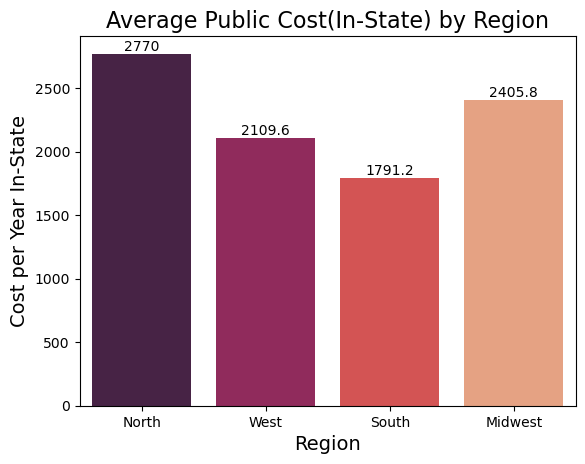

In [29]:
clean_incost_df = college_df.dropna(subset=['in-state tuition'])
clean_incost_public_df = clean_incost_df[clean_incost_df['Public/Private'] == 1]

print(f"Mean per Region\n ------------------\n {clean_incost_df.groupby('Region')['in-state tuition'].mean()}")
North = clean_incost_public_df[clean_incost_public_df['Region'] == 'North']['in-state tuition']
West = clean_incost_public_df[clean_incost_public_df['Region'] == 'West']['in-state tuition']
South = clean_incost_public_df[clean_incost_public_df['Region'] == 'South']['in-state tuition']
Midwest = clean_incost_public_df[clean_incost_public_df['Region'] == 'Midwest']['in-state tuition']
fvalue, pvalue = stats.f_oneway(North, West, South, Midwest)
print(f'fvalue={fvalue}, pvalue={pvalue}')

print(ttest_ind(West,South, equal_var=False))
print(ttest_ind(Midwest,West, equal_var=False))
print(ttest_ind(North,Midwest, equal_var=False))


means=[round(North.mean(),1), 
       round(West.mean(),1),
       round(South.mean(),1),
       round(Midwest.mean(),1)]
ax = sns.barplot(x=['North', 'West', 'South', 'Midwest'], y=means, palette='rocket', )
plt.title('Average Public Cost(In-State) by Region', fontsize=16)
plt.ylabel('Cost per Year In-State', fontsize=14)
plt.xlabel('Region',fontsize=14)
for i in ax.containers:
    ax.bar_label(i,)

plt.savefig('images/Average Public Cost(In-State) by Region.png', bbox_inches='tight')
plt.show()


Mean per Region
 ------------------
 Region
Midwest     9258.782235
North      11454.410959
South       7132.613861
West        9751.475610
Name: out-of-state tuition, dtype: float64
fvalue=18.14586886782207, pvalue=3.897390493224823e-11
Ttest_indResult(statistic=6.361147381272435, pvalue=2.71681073133887e-09)
Ttest_indResult(statistic=-2.433803999574093, pvalue=0.015980715134429443)
Ttest_indResult(statistic=1.1097865541446519, pvalue=0.2683843435451707)


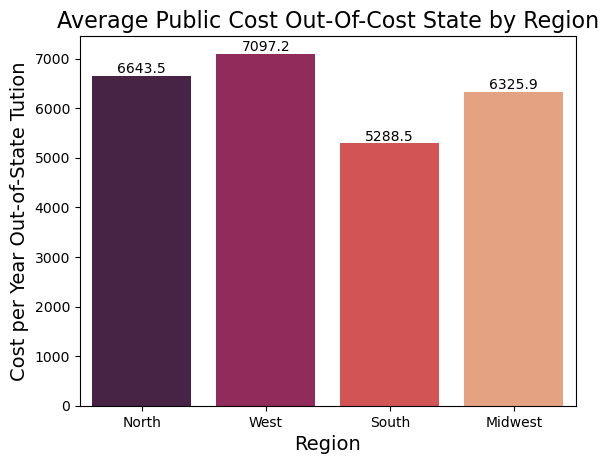

In [30]:
clean_incost_df = college_df.dropna(subset=['out-of-state tuition'])
clean_incost_public_df = clean_incost_df[clean_incost_df['Public/Private'] == 1]

print(f"Mean per Region\n ------------------\n {clean_incost_df.groupby('Region')['out-of-state tuition'].mean()}")
North = clean_incost_public_df[clean_incost_public_df['Region'] == 'North']['out-of-state tuition']
West = clean_incost_public_df[clean_incost_public_df['Region'] == 'West']['out-of-state tuition']
South = clean_incost_public_df[clean_incost_public_df['Region'] == 'South']['out-of-state tuition']
Midwest = clean_incost_public_df[clean_incost_public_df['Region'] == 'Midwest']['out-of-state tuition']
fvalue, pvalue = stats.f_oneway(North, West, South, Midwest)
print(f'fvalue={fvalue}, pvalue={pvalue}')

print(ttest_ind(West,South, equal_var=False))
print(ttest_ind(Midwest,West, equal_var=False))
print(ttest_ind(North,Midwest, equal_var=False))


means=[round(North.mean(),1), 
       round(West.mean(),1),
       round(South.mean(),1),
       round(Midwest.mean(),1)]
ax = sns.barplot(x=['North', 'West', 'South', 'Midwest'], y=means, palette='rocket', )
plt.title('Average Public Cost Out-Of-Cost State by Region', fontsize=16)
plt.ylabel('Cost per Year Out-of-State Tution', fontsize=14)
plt.xlabel('Region',fontsize=14)
for i in ax.containers:
    ax.bar_label(i,)

plt.savefig('images/Average Public Cost(Out-of-State) by Region.png', bbox_inches='tight')
plt.show()


In [31]:
import geopandas as gpd
import geoplot.crs as gcrs
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable



shapefile_path = 'data/original_data/tl_2016_us_state.shp'
gdf = gpd.GeoDataFrame.from_file(shapefile_path)


count_state_df = college_df.groupby('State')['State'].count().reset_index(name='Count')

gdf = gdf.merge(count_state_df, left_on='STUSPS', right_on='State')

# ax = geoplot.kdeplot(count_state_df, projection=gcrs.AlbersEqualArea())

#fig, ax = plt.subplots(1, figsize=(10, 6))
gdf.plot(column='Count', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)


# Add titles and labels (optional)
ax.set_title('Heatmap of Values by State', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: Your Source', xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Remove axes
ax.axis('off')

# Show plot
plt.show()

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<Figure size 640x480 with 0 Axes>